# Finding regions under selection

## [paper title]


use the sch_man_nwinvasion-selection conda env

In [1]:
import scipy.stats
#import statsmodels.api as sm
#import statsmodels as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import allel
import shutil
import math
import yaml
import pandas as pd
from intervaltree import IntervalTree
from collections import defaultdict
from scipy import stats
from scipy import signal
from pathlib import Path
import pybedtools
import gffutils
import itertools
from tqdm import tqdm
import random

In [2]:
os.chdir("/master/nplatt/sch_man_nwinvasion")

Calculate the cumulative length fo each chromosome for downstream plotting

In [3]:
#make sure that all stops are not gt chrom length
chr_length = {}
#genome_size = 0
with open('/master/nplatt/sch_man_nwinvasion/data/genomes/Smansoni_v7.fa.fai', 'r') as fai:
    for entry in fai:
        chrom, length, *offset = entry.rstrip().split("\t")
        chr_length[chrom]=int(length)

    cumul_start={}
    cumul_start['SM_V7_1']=0
    cumul_start['SM_V7_2']= cumul_start['SM_V7_1'] + chr_length['SM_V7_1']
    cumul_start['SM_V7_3']= cumul_start['SM_V7_2'] + chr_length['SM_V7_2']
    cumul_start['SM_V7_4']= cumul_start['SM_V7_3'] + chr_length['SM_V7_3']
    cumul_start['SM_V7_5']= cumul_start['SM_V7_4'] + chr_length['SM_V7_4']
    cumul_start['SM_V7_6']= cumul_start['SM_V7_5'] + chr_length['SM_V7_5']
    cumul_start['SM_V7_7']= cumul_start['SM_V7_6'] + chr_length['SM_V7_6']
    scanned_size = cumul_start['SM_V7_7'] + chr_length['SM_V7_7']

In [4]:
#read in vcf file
filtered_callset=allel.read_vcf('results/variant_filtration/smv7_ex_autosomes.vcf')

# How many SNPs are segregating on Chr 1 per pop

In [15]:
for pop in ["tanzania", "brazil", "senegal", "niger"]:
    seg=np.sum(pop_ac[pop].is_segregating())
    chr1_seg=np.sum(pop_ac[pop][0:162218].is_segregating())
    print("{} chr1={} total={}".format(pop, chr1_seg, seg))

tanzania chr1=29765 total=98136
brazil chr1=8947 total=33042
senegal chr1=9381 total=35593
niger chr1=6107 total=24017


# Genome-wide Summary Stats

## Pi, Tajima's D, Theta, Ne

In [45]:
for pop in ["rodhaini", "brazil", "niger", "senegal", "tanzania"]:
    accessible_genome_size = 0
    pi_s=[]
    td_s=[]
    theta_s=[]
    mu=8.1e-9

    #now loop through each chromosome
    for chrom in list(set(filtered_callset['variants/CHROM'])) :
        target_sites = filtered_callset['variants/CHROM'] == chrom

     
        chr_poss = filtered_callset['variants/POS'][target_sites]
        chr_acs  = pop_ac[pop][target_sites]
        chr_len  = len(accessible_bases[chrom])
        

        chr_pi    = allel.sequence_diversity(chr_poss, chr_acs, start=1, stop=chr_len, is_accessible=accessible_bases[chrom])
        chr_theta = allel.watterson_theta(chr_poss, chr_acs, is_accessible=accessible_bases[chrom])
        chr_td    = allel.tajima_d(chr_acs, pos=chr_poss, start=1, stop=chr_len, min_sites=3)


        num_accessible_bases = sum(accessible_bases[chrom])
        theta_s += [chr_theta] * num_accessible_bases
        pi_s    += [chr_pi]    * num_accessible_bases
        td_s    += [chr_td]    * num_accessible_bases

        accessible_genome_size += num_accessible_bases

    pi    = np.mean(pi_s)
    td    = np.mean(td_s)
    theta = np.mean(theta_s)
    ne = theta/(4 * mu)

    outline="{}:{}\t{}\t{}\t{}".format(pop, pi, td, theta, ne)
    print(outline)

rodhaini:0.000482784736658036	0.4786576179515533	0.0004285068495203049	13225.520046922991
brazil:0.0006229634190808082	0.22480080261256646	0.0005842378015352539	18032.03091158191
niger:0.0005282391905747682	-0.5633207858097302	0.000607062748979703	18736.50459813898
senegal:0.000452726735843687	-1.4171249923020972	0.0007125456426101054	21992.149463274858
tanzania:0.0013144180653959314	-0.7287596992860278	0.0016688696510230978	51508.32256244129


## Fst

In [9]:
pops = [ 'rodhaini', 'caribbean', 'tanzania',
         'senegal',  'niger',     'brazil' ]

pop_combs=list(itertools.combinations(pops, 2)) 

with open("results/fst/genome_wide_fst.csv", 'w') as out_csv:
    out_csv.write("pop1,pop2,fst,se\n")
    print("pop1\tpop2\tfst\tse")

    for pop1, pop2 in pop_combs:

        idxs=[pop_idxs[pop1], pop_idxs[pop2]]

        #allel.average_weir_cockerham_fst(g, subpops, blen, max_allele=None)
        fst, se, block_fsts, jacknife_fsts = allel.average_weir_cockerham_fst(gt, idxs, 100)

        outline="{}\t{}\t{}\t{}".format(pop1, pop2, fst, se)
        print(outline)
        
        out_csv.write(outline.replace("\t", ",")+"\n")

pop1	pop2	fst	SE
rodhaini	caribbean	0.928506200479594	0.0012228434103421389
rodhaini	tanzania	0.8439788473873892	0.001616842545372161
rodhaini	senegal	0.9370016347766583	0.001296004539097002
rodhaini	niger	0.9305794094480899	0.0011327164324128835
rodhaini	brazil	0.9189907169217962	0.001343597256193136
caribbean	tanzania	0.2789521159568736	0.0036073079664987
caribbean	senegal	0.32307932601975586	0.008473085940511469
caribbean	niger	0.23645993744180765	0.00707938775077595
caribbean	brazil	0.15369549738924515	0.006733044751663753
tanzania	senegal	0.41553169413628227	0.00321957992128926
tanzania	niger	0.3478709508995357	0.0031245927121814343
tanzania	brazil	0.3790452130775332	0.0034260999716080004
senegal	niger	0.13546469500849986	0.0042380948004846425
senegal	brazil	0.23465523710207586	0.0046503734975993725
niger	brazil	0.15190265241779138	0.0036320702629908355


# Fst (sliding window)

# Tajimas D boxplot

In [23]:
td_dfs=defaultdict(lambda: pd.DataFrame(columns=["tajimas_d", "start", "stop", "n_snps", "chrom"]))

tds=defaultdict(lambda: [])
for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    for chrom in uniq_chroms:
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]
        chrom_ac = pop_ac[pop][mask]
        td, windows, counts = allel.windowed_tajima_d(chrom_pos, chrom_ac, 100_000, min_sites=3)

        #add info to a df
        chr_df=pd.DataFrame([td, windows[:,0], windows[:,1], counts]).T
        chr_df.columns=["tajimas_d", "start", "stop", "n_snps"]
        chr_df["chrom"]=chrom
        
        td_dfs[pop]=td_dfs[pop].append(chr_df)
        
    #reset index
    td_dfs[pop]=td_dfs[pop].reset_index(drop=True)
    
    #save df to a csv
    td_dfs[pop].to_csv("results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop), index=False, sep=",")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:04<00:00,  1.49it/s]


In [30]:
td_dfs={}

for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    td_dfs[pop] = pd.read_csv("results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop), sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.52it/s]


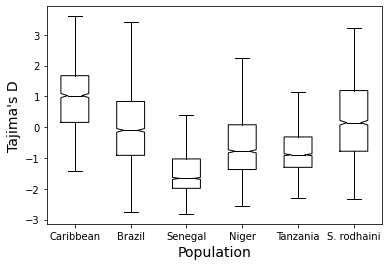

In [49]:
n_snp_filt = 50 
plt.boxplot([td_dfs["caribbean"][td_dfs["caribbean"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna(),
             td_dfs["brazil"][td_dfs["brazil"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna(),
             td_dfs["senegal"][td_dfs["senegal"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna(),
             td_dfs["niger"][td_dfs["niger"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna(), 
             td_dfs["tanzania"][td_dfs["tanzania"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna(),
             td_dfs["rodhaini"][td_dfs["rodhaini"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna() ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "S. rodhaini"],
             medianprops=dict(color="black", lw=1))
plt.xlabel("Population", fontsize=14)
plt.ylabel("Tajima's D", fontsize=14)
plt.savefig("results/tajimas_d/tajimas_d_boxplot_100kb_windows.svg")
plt.savefig("results/tajimas_d/tajimas_d_boxplot_100kb_windows.png", dpi=300)
plt.show()

In [38]:

print("pop,mean_td,se_td,95%cis_mean,n")
for pop in ['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']:
    tds=td_dfs[pop][td_dfs[pop]["n_snps"]>n_snp_filt]["tajimas_d"].dropna()
    
    mean = np.mean(tds)
    se = scipy.stats.sem(tds)
    cis=scipy.stats.norm.interval(0.95, loc=mean, scale=se)
    n=len(tds)
    
    print("{},{},{},{},{}".format(pop, mean, se, cis, n))

pop,mean_td,se_td,95%cis,n
rodhaini,0.2742165750953685,0.027467973018245793,(0.2203803372512888, 0.3280528129394482),1712
caribbean,0.9292112420732257,0.030069808879663287,(0.870275499647083, 0.9881469844993684),1292
brazil,0.03350175689031385,0.026037245315890932,(-0.017530306185466596, 0.0845338199660943),2199
niger,-0.5789530239728338,0.023114971796841754,(-0.6242575361983027, -0.5336485117473648),1962
senegal,-1.3751618597317719,0.01943331948423521,(-1.4132504660209333, -1.3370732534426104),2226
tanzania,-0.739016026493962,0.016864994806237373,(-0.7720708089136423, -0.7059612440742817),2348


In [54]:
pop_idxs["caribbean"]

[10, 11, 12]

In [53]:
btds=td_dfs["brazil"][td_dfs["brazil"]["n_snps"]>n_snp_filt]["tajimas_d"].dropna()


for pop in ["niger", "senegal", "tanzania"]:
    xtds=td_dfs[pop][td_dfs[pop]["n_snps"]>n_snp_filt]["tajimas_d"].dropna()
    t, p = stats.ttest_ind(btds, xtds, equal_var=False)
    print("brazil vs {}: {}, {}".format(pop, t, p))

brazil vs niger: 17.590561897548202, 7.41570199968281e-67
brazil vs senegal: 43.357001785335285, 0.0
brazil vs tanzania: 24.902233810553998, 6.251274135983254e-127


In [52]:
stats.ttest_ind(btds, xtds, equal_var=False)

Ttest_indResult(statistic=24.902233810553998, pvalue=6.251274135983254e-127)

# Pi sliding window

In [9]:
pops= list(pop_idxs.keys()) 

#get genotypes
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])

#now get allele count per population
ac=gt.count_alleles()

pop_ac={}
for pop in pops:
    pop_ac[pop] = gt.count_alleles(subpop=pop_idxs[pop])

In [10]:
uniq_chroms=list(set(filtered_callset['variants/CHROM']))
uniq_chroms.sort()

In [216]:
pi_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "start", "stop", "n_bases", "n_snps", "chrom"]))

pis=defaultdict(lambda: [])
for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    for chrom in uniq_chroms:
        mask=filtered_callset['variants/CHROM']==chrom
        chrom_pos = filtered_callset['variants/POS'][mask]
        chrom_ac = pop_ac[pop][mask]
        pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, 100_000, is_accessible=accessible_bases[chrom])

        #add info to a df
        chr_df=pd.DataFrame([pi, windows[:,0], windows[:,1], nbases, counts]).T
        chr_df.columns=["pi", "start", "stop", "n_bases", "n_snps"]
        chr_df["chrom"]=chrom
        
        pi_dfs[pop]=pi_dfs[pop].append(chr_df)
   
    #reset index
    pi_dfs[pop]=pi_dfs[pop].reset_index(drop=True)
        
    #save df to a csv
    pi_dfs[pop].to_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop), index=False, sep=",")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:57<00:00, 19.51s/it]


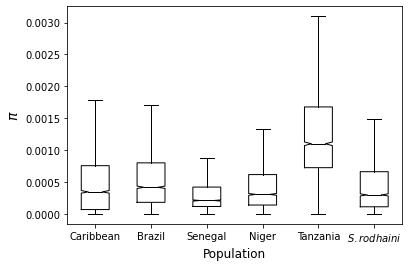

In [26]:
plt.boxplot([ pi_dfs["caribbean"].dropna(subset=["pi"])["pi"],
              pi_dfs["brazil"].dropna(subset=["pi"])["pi"],
              pi_dfs["senegal"].dropna(subset=["pi"])["pi"],
              pi_dfs["niger"].dropna(subset=["pi"])["pi"], 
              pi_dfs["tanzania"].dropna(subset=["pi"])["pi"],
              pi_dfs["rodhaini"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
             medianprops=dict(color="black", lw=1))
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig("results/pi/pi_boxplot_100kb_windows.svg")
plt.savefig("results/pi/pi_boxplot_100kb_windows.png", dpi=300)
plt.show()


# F3

In [11]:
#allel.average_patterson_f3(acc, aca, acb, blen, normed=True)[source]

dict_keys(['samples', 'calldata/GT', 'variants/ALT', 'variants/CHROM', 'variants/FILTER_PASS', 'variants/ID', 'variants/POS', 'variants/QUAL', 'variants/REF'])

In [7]:
allel.average_patterson_f3(pop_ac["brazil"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)


/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = (ac[:, 0] * ac[:, 1]) / (an * (an - 1))
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:359: RuntimeWarning: divide by zero encountered in true_divide
  vb = T_bsum / B_bsum
/master/nplatt/miniconda3/envs/sch_man_nwinvasion-jupyter/lib/python3.8/site-packages/allel/stats/admixture.py:359: RuntimeWarning: invalid value encountered in true_divide
  vb = T_bsum / B_bsum


(0.7642687717897145,
 0.02070652497665151,
 36.90956221053494,
 array([2.30770842, 0.38621328, 2.60482947, ..., 2.16391042, 2.00865931,
        0.5053442 ]),
 array([0.76363462, 0.76462773, 0.76375805, ..., 0.76407041, 0.76402817,
        0.76435461]))

In [8]:
allel.average_patterson_f3(pop_ac["niger"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)

(0.99263110166744,
 0.029885483308429644,
 33.21449050775276,
 array([1.87430761, 0.42550039, 1.06493091, ..., 1.74566325, 8.69340121,
        0.45554722]),
 array([0.99205936, 0.99310809, 0.9925732 , ..., 0.99246997, 0.99211768,
        0.9928036 ]))

In [9]:
allel.average_patterson_f3(pop_ac["senegal"],
                           pop_ac["rodhaini"],
                           pop_ac["tanzania"],
                           blen=100,
                           normed=True)

(1.2648039000192297,
 0.046112799000395034,
 27.42847815437086,
 array([2.30182821, 1.01034066, 7.12026285, ..., 1.39569625, 2.63755556,
        1.16257658]),
 array([1.26427968, 1.26501592, 1.26402984, ..., 1.26485081, 1.26458232,
        1.26490291]))

# D; ABBA BABA

## genome wide

In [ ]:
#allel.average_patterson_d(aca, acb, acc, acd, blen)
allel.average_patterson_d(pop_ac["brazil"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

In [ ]:
allel.average_patterson_d(pop_ac["niger"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

In [ ]:
allel.average_patterson_d(pop_ac["senegal"],
                          pop_ac["tanzania"],
                          pop_ac["rodhaini"],
                          pop_ac["margrebowiei"],
                          blen=1000)

## at region with high rod alleles from loter

In [53]:
#get variants from region: SM_V7_2:31,708,474-32,212,727
x=np.logical_and( filtered_callset['variants/POS'] >= 31_708_474,
                  filtered_callset['variants/POS'] <= 32_212_727)
y=np.logical_and(x,
                 filtered_callset['variants/CHROM'] == "SM_V7_2")



num, den = allel.patterson_d(pop_ac["brazil"][y],
                             pop_ac["tanzania"][y],
                             pop_ac["rodhaini"][y],
                             pop_ac["margrebowiei"][y])

In [65]:
num=num[~np.isnan(num)]
den=den[~np.isnan(den)]

In [82]:
target_d=num.sum()/den.sum()
target_d

-0.8712250892015296

In [69]:
d, se, z, d_block, n_block = allel.average_patterson_d(pop_ac["brazil"],
                                                       pop_ac["tanzania"],
                                                       pop_ac["rodhaini"],
                                                       pop_ac["margrebowiei"],
                                                       blen=1000)


In [81]:
d_block.mean()

-0.016875737747302933

In [76]:
stats.percentileofscore(d_block, target_d, kind="rank")

2.9473684210526314

# D3

In [17]:
os.mkdir("results/d3")

In [7]:
d = allel.pairwise_distance(gt.to_n_alt(), metric='euclidean')

In [8]:
pw_d = scipy.spatial.distance.squareform(d)

In [9]:
pw_df = pd.DataFrame(pw_d, columns = samples, index=samples)
pw_df = pw_df/len(gt)

pw_df.to_csv("results/d3/pairwise_pdistance.csv", sep=",")

In [10]:
samples_per_pop = defaultdict(lambda: [])

for sample in pop_assign:
    pop = pop_assign[sample]
    samples_per_pop[pop].append(sample)
    

In [11]:
def random_block_d3(pop_a, pop_b, pop_c, block_size, gt_array):
    x = random.sample(range(0,len(gt)-block_size), 1)[0]
    block_gt = gt_array[x:x+block_size]
    
    block_dist = allel.pairwise_distance(block_gt.to_n_alt(), metric='euclidean')
    block_dist = scipy.spatial.distance.squareform(block_dist)
    block_df = pd.DataFrame(block_dist, columns = samples, index=samples)
    block_pw_df = block_df/len(gt)

    dac = block_pw_df.loc[samples_per_pop[pop_a], samples_per_pop[pop_c]].values.mean()
    dbc = block_pw_df.loc[samples_per_pop[pop_b], samples_per_pop[pop_c]].values.mean()
    
    d3=(dbc-dac)/(dbc+dac)

    return(d3)

In [12]:
combos = [ ("brazil",    "tanzania"), 
           ("niger",     "tanzania"), 
           ("senegal",   "tanzania"), 
           ("cameroon",  "tanzania"),
           ("caribbean", "tanzania"), 
           ("uganda",    "tanzania") ]

d3s = []
comparison_labels=[]

for pop_a, pop_b in tqdm(combos, desc="Combos"):

    label = "({},{}){}".format(pop_a, pop_b, "Sr")
    comparison_labels.append(label)
    
    combo_d3s=[]
    for i in tqdm(range(0,1_000), desc = "bootstrapping"):
        
        d3 = random_block_d3(pop_a, pop_b, "rodhaini", 1_000, gt)
        combo_d3s.append(d3)
        
    d3s.append(combo_d3s)

Combos:   0%|          | 0/6 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

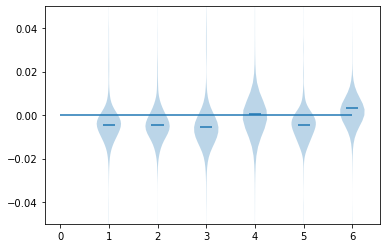

In [13]:
plt.violinplot(d3s, showextrema=False, showmeans=True)
plt.ylim(-0.05, 0.05)
plt.hlines(0, 0, len(d3s))
#plt.xlabels(comparison_labels)
#plt.savefig("results/d3/d3.svg")
plt.show()


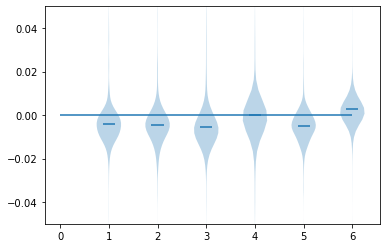

In [10]:
plt.violinplot(d3s, showextrema=False, showmeans=True)
plt.ylim(-0.05, 0.05)
plt.hlines(0, 0, len(d3s))
#plt.xlabels(comparison_labels)
plt.savefig("results/d3/d3.svg")
plt.show()


In [30]:
for i in range(len(d3s)):
    d3_mean = np.array(d3s[i]).mean()
    d3_std = np.array(d3s[i]).std()
    d3_sem = scipy.stats.sem(d3s[i])
    d3_0z = (0-d3_mean)/d3_std
    comp = comparison_labels[i]
    out = "{} - mean {} sem {} z {}".format(comp, d3_mean, d3_sem, d3_0z)
    print(out)

(brazil,tanzania)Sr - mean -0.004720852896774627 sem 0.0003576299668106418 z 0.417641667792854
(niger,tanzania)Sr - mean -0.004560228845382902 sem 0.0003440201099468939 z 0.41939192369931866
(senegal,tanzania)Sr - mean -0.00538156214567549 sem 0.0004817839402108949 z 0.35340549389358533
(cameroon,tanzania)Sr - mean 0.00046427266133737283 sem 0.0006621534770245247 z -0.02218358351490054
(caribbean,tanzania)Sr - mean -0.004753340817546751 sem 0.00029100766329161925 z 0.516787243387249
(uganda,tanzania)Sr - mean 0.0034022709374206647 sem 0.0006169041726716121 z -0.17448915661050748


In [25]:
#z=(x-mean/)SD
#abs(d3_mean)/d3_sem

(0-d3_mean)/d3_std

-0.17448915661050748

In [ ]:
scipy.stats.zscore(d3s[i])

In [29]:
(d3s[i][0]-d3_mean)/d3_std

-0.14801276298268887

# msprime 

In [35]:
%%bash

mkdir -p results/msprime/logs

CONDA="conda activate sch_man_nwinvasion-msprime;"
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 "    

for POP in tanzania senegal niger brazil; do
    mkdir results/msprime/$POP
    for I in $(seq 1 100); do
        MSPRIME_CMD="python code/msprime-qsub.py $POP $I"       
        echo "$CONDA $MSPRIME_CMD" | $QSUB -N $POP"_"$I -o results/msprime/logs/$POP"_"$I.log
    done
done


#--------------------------------------------------------------------------------------------------------
# msprime-qsub.py
#--------------------------------------------------------------------------------------------------------

# import msprime
# import os
# import subprocess
# import sys
# from random import randint

# pop = sys.argv[1]
# iteration = sys.argv[2]

# #################################
# def sim_tree(iteration, pop, length, recomb_rate, mut_rate, seed):
    
#     tree_sequence = msprime.simulate( sample_size=n_samples[pop], 
#         Ne=ne[pop], 
#         length=88.9e6, 
#         recombination_rate=3.4e-8,
#         mutation_rate=8.1e-9,
#         random_seed=seed)

#     print("iter {}: {} completed".format(iteration, pop))
#     #print(tree.draw(format="unicode"))

#     with open("results/msprime/{}/chr1_{}_rep_{}_seed_{}.vcf".format(pop, pop, iteration, seed), "w") as vcf_file:
#         tree_sequence.write_vcf(vcf_file, ploidy=2)
# ########################################

# #calcualted by est_pop_params.py
# ne = { "brazil"      : 18293,
#        "niger"       : 19971,
#        "senegal"     : 22421,
#        "tanzania"    : 52234 }

# n_samples = { "brazil"   : 48*2,
#               "senegal"  : 25*2,
#               "niger"    : 10*2,
#               "tanzania" : 58*2  }

# seed = randint(0,1e6)
# sim_tree(iteration, pop, 88e-9, 3.4e-8, 8.1e-9, seed)

Your job 5672368 ("tanzania_1") has been submitted
Your job 5672369 ("tanzania_2") has been submitted
Your job 5672370 ("tanzania_3") has been submitted
Your job 5672371 ("tanzania_4") has been submitted
Your job 5672372 ("tanzania_5") has been submitted
Your job 5672373 ("tanzania_6") has been submitted
Your job 5672374 ("tanzania_7") has been submitted
Your job 5672375 ("tanzania_8") has been submitted
Your job 5672376 ("tanzania_9") has been submitted
Your job 5672377 ("tanzania_10") has been submitted
Your job 5672378 ("tanzania_11") has been submitted
Your job 5672379 ("tanzania_12") has been submitted
Your job 5672380 ("tanzania_13") has been submitted
Your job 5672381 ("tanzania_14") has been submitted
Your job 5672382 ("tanzania_15") has been submitted
Your job 5672383 ("tanzania_16") has been submitted
Your job 5672384 ("tanzania_17") has been submitted
Your job 5672385 ("tanzania_18") has been submitted
Your job 5672386 ("tanzania_19") has been submitted
Your job 5672387 ("ta

Now after all the jobs have finished the through the scheudler take each simulated chrom and extract only the snps that fall within exome-probed regions

In [ ]:
#--------------------------------------------------------------------------------------------------------
# msprime-probe_snps_from_vcf.py
#--------------------------------------------------------------------------------------------------------

import msprime
import os
import subprocess
import glob


#now create bed for the new "sim" chr1
with open('data/renamed-sma_agilent_baits.v7.0.chr_reorderd.bed', 'r') as in_bed:
    with open('results/msprime/sim_probes.bed', 'w') as out_bed:
        for bed_entry in in_bed:
            chrom, start, stop = bed_entry.rstrip().split("\t")
            if chrom == "SM_V7_1":
                out_bed.write("1\t{}\t{}\n".format(start, stop))

bed = 'results/msprime/sim_probes.bed'
#now loop through all of the sim vcf files to get snps at probed regions
for pop in ["niger", "senegal", "tanzania", "brazil"]:
    out_dir = "results/msprime/{}".format(pop)
    
    sim_vcfs = glob.glob("{}/chr1_*_rep_*.vcf".format(out_dir))
    for sim_vcf in sim_vcfs:

        probed_vcf = sim_vcf.replace(".vcf", "_probed.vcf")         
        jid = "probe_{}".format(probed_vcf.split("/")[-1])
        log = "{}/logs".format(out_dir)

        vcf_cmd = "vcftools --vcf {} --bed {} --recode --recode-INFO-all --stdout >{}".format(sim_vcf, bed, probed_vcf)
        qsub_cmd =  "qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 3 -N {} -o {}".format(jid, log)
        conda_cmd = "conda activate sch_man_nwinvasion-msprime"

        cmd ="echo \"{}; {}\" | {}".format(conda_cmd, vcf_cmd, qsub_cmd)

        #run vcf cmd
        #process = subprocess.Popen(cmd.split(""),
        #                     stdout=subprocess.PIPE, 
        #                     stderr=subprocess.PIPE)
        !{cmd}

# H-scan

HSCAN identifies regions under selection based on the length of haplotypes.  (citation).  We used a custom code to convert HSCAN to VCF input formats.

Run on actual data with:
```code/hscan-run_with_real_data.sh```

Repeat the process on simulated data:

```code/hscan-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [38]:
#% bash

#code/hscan-run_with_real_data.sh
#code/hscan-run_with_sim_data.sh

## Combine runs, smooth H, and generate a .csv file

In [28]:
#SET WINDOW SMOOTHING SIZE HERE
window=201

In [29]:
#cycle through each population to calculate generate csv file with H scores, etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    print(pop)

    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    h_s=[]
    smoothed_h_s=np.array([])

    #read all the hscan output for the population into lists for chrom, h, and pos
    for i in range(1,8):
        tmp_chr_h_s=[]

        chrom = "SM_V7_{}".format(i)
        
        with open("results/hscan/{}/{}_{}.hscan-out".format(pop, chrom, pop), 'r') as hscan_file:
            #skip the header line
            next(hscan_file)
            
            for calc in hscan_file:
                
                pos, h = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                tmp_chr_h_s.append(h)
                h_s.append(h)
                pos_s.append(pos)

        #smooth the h_s for this chromosome and add to an array
        smoothed_h=scipy.signal.medfilt(np.array(tmp_chr_h_s).astype(float), window)
        smoothed_h_s=np.append(smoothed_h_s, smoothed_h)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    h_s=np.array(h_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "h", "smoothed_h"]
    df = pd.DataFrame(data = [chrom_s, pos_s, h_s, smoothed_h_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(row["pos"]) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/hscan/{}_hscan.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')


niger
senegal
brazil
tanzania


# Sweepfinder2

Run Sweepfinder2 on actual data (preps files, calculates pop-specific SFS, then runs Sweepfinder2:

```code/sweepfinder2-run_with_real_data.sh```

Repeat the process on simulated data:

```code/sweepfinder2-run_with_sim_data.sh```

Once those analyses are finished come back here to process the results

In [39]:
#% bash

#code/sweepfinder2-run_with_real_data.sh
#code/sweepfinder2_sim_data.sh

## Combine runs and generate a .csv file


In [37]:
#cycle through each population to calculate generate csv file with H scores, pvalues etc. 
for pop in ["niger", "senegal", "brazil", "tanzania"]:
    print(pop)
    
    #make sure lists are clean
    chrom_s=[]
    pos_s=[]
    lr_s=[]

    #read all the sweepfinder output for the population into lists for chrom, lr, and pos
    for i in range(1,8):
        chrom = "SM_V7_{}".format(i)
        
        with open("results/sweepfinder/{}/{}_{}.sf2out".format(pop, chrom, pop), 'r') as sf2_file:
            #skip header line
            next(sf2_file)
            for calc in sf2_file:
                
                pos, lr, alpha = calc.rstrip().split("\t")
                
                chrom_s.append(chrom)
                lr_s.append(lr)
                pos_s.append(pos)

    #convert the lists to numpy arrays
    chrom_s=np.array(chrom_s)
    pos_s=np.array(pos_s)
    lr_s=np.array(lr_s).astype(np.float)
    
    #now add all info to a data table
    columns = ["chrom", "pos", "lr"]
    df = pd.DataFrame(data = [chrom_s, pos_s, lr_s]).T
    df.columns=columns

    #get cumulative positions along the genome (additive positions; used to easily organize data in chr order)
    fig_x_pos_s=[]
    for index, row in df.iterrows(): 
        fig_x_pos_s.append(int(float(row["pos"])) + int(cumul_start[row['chrom']]))

    df['fig_x_pos']=fig_x_pos_s
    df = df.sort_values(["fig_x_pos"], ascending = True)

    #save data to csv file
    csv_file ="results/sweepfinder/{}_sf2.csv".format(pop)
    df.to_csv(csv_file, index=False, header=True, mode='w')

niger
senegal
brazil
tanzania


# Reconcile sliding window stats per site

In [5]:
if not os.path.exists("results/selection_peaks"):
    os.mkdir("results/selection_peaks")

In [6]:
#create an interval tree and add the GENEs from the gff file to it
gff_df = pd.read_csv( "data/genomes/Sm_v7.0.gff", 
                      sep="\t", 
                      comment='#', 
                      header=None)

#process the gff
#...by only keeping "gene" entries
gff_df = gff_df[gff_df[2] == "gene"]

# and keeping a single gene ID per entry
genes = []
for index, row in gff_df.iterrows():
    gene = row[8].split(";")[0].replace("ID=", "")
    genes.append(gene)
    
gff_df["gene"] = genes

#now add to an interval tree
gene_trees = defaultdict(lambda: IntervalTree())

for index, row in tqdm(gff_df.iterrows(), total = len(gff_df)):
    gene_trees[row[0]][row[3] : row[4]] = row["gene"]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10163/10163 [00:00<00:00, 15529.91it/s]


In [7]:
dfs={}

for pop in ["tanzania", "senegal", "brazil", "niger"]:
    #print(pop)
    
    #designate files and read into dfs
    hscan_file      = "results/hscan/{}_hscan.csv".format(pop)
    sweep_file      = "results/sweepfinder/{}/{}_sf2.csv".format(pop, pop)
    pi_file         = "results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop)
    td_file         = "results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop)
    pcadapt_file    = "results/pcadapt/pcadapt.csv"

    #read in to dfs    
    hscan_df = pd.read_csv(hscan_file,   sep=",")
    sweep_df = pd.read_csv(sweep_file,   sep=",")
    pi_df    = pd.read_csv(pi_file,      sep=",").dropna()
    td_df    = pd.read_csv(td_file,      sep=",").dropna()
    pca_df   = pd.read_csv(pcadapt_file, sep=",").dropna()

    #create empty interval trees to store the data
    h_trees     = defaultdict(lambda: IntervalTree())
    sweep_trees = defaultdict(lambda: IntervalTree())
    pi_trees    = defaultdict(lambda: IntervalTree())
    fst_trees   = defaultdict(lambda: IntervalTree())
    td_trees    = defaultdict(lambda: IntervalTree())
    pca_trees   = defaultdict(lambda: IntervalTree())
    
    #for each stat, add the values to the interval tree
    for index, row in hscan_df.iterrows():
        h_trees[row["chrom"]][row["pos"] : row["pos"]+1] = row["h"]

    for index, row in sweep_df.iterrows():
        sweep_trees[row["chrom"]][row["pos"]: row["pos"]+1001]=row["lr"]

    for index, row in pi_df[pi_df["n_snps"]>25].iterrows():
         pi_trees[row["chrom"]][row["start"]: row["stop"]] = row["pi"]

    for index, row in td_df[td_df["n_snps"]>25].iterrows():
         td_trees[row["chrom"]][row["start"]: row["stop"]] = row["tajimas_d"]
            
    for index, row in pca_df.iterrows():
         pca_trees[row["chrom"]][row["pos"]: row["pos"]+1] = row["padj"]
            
    #now go through each snp in the vcf file and add the stats for that locus or the stat from the region/window"
    hs    = []
    lrs   = []
    pis   = []
    tds   = []
    pcas  = []
    genes = []
    
    for chrom, pos in tqdm(zip(filtered_callset['variants/CHROM'], 
                               filtered_callset['variants/POS'] ), 
                           total = len(filtered_callset['variants/CHROM']), 
                           desc  = "Reconciling {} stats".format(pop)):
    
        try:
            hs.append(list(h_trees[chrom][pos])[0].data)
        except:
            hs.append(float("nan"))

        try:
            lrs.append(list(sweep_trees[chrom][pos])[0].data)
        except:
            lrs.append(float("nan"))

        try:
            pis.append(list(pi_trees[chrom][pos])[0].data)
        except:
            pis.append(float("nan"))

        try:
            tds.append(list(td_trees[chrom][pos])[0].data)
        except:
            tds.append(float("nan"))

        try:
            pcas.append(list(pca_trees[chrom][pos])[0].data)
        except:
            pcas.append(float("nan"))
            
        try:
            genes.append(list(gene_trees[chrom][pos])[0].data)
        except:
            genes.append(float("nan"))            
            
        
    #create a dataframe
    df = pd.DataFrame(data = [ filtered_callset['variants/CHROM'], 
                               filtered_callset['variants/POS'], 
                               hs, 
                               lrs, 
                               pis, 
                               tds, 
                               pcas, 
                               genes ]).T
    df.columns = [ "chrom", 
                   "pos", 
                   "h", 
                   "lr", 
                   "pi", 
                   "tajimas_d", 
                   "pcadapt-padj", 
                   "gene" ]
    
    #get percentile ranks
    df["h_prank"]  = df["h"].rank(pct=True)
    df["lr_prank"] = df["lr"].rank(pct=True)

    #since we didn't include tanzania in the pcadapt run it can be excluded here (all values to NaN)
    if pop == "tanzania":
        df["pcadapt-padj"]=np.nan
    
    #save to a file
    df.to_csv( "results/selection_peaks/raw_scores_{}.csv".format(pop), 
               sep=",", 
               index=False, 
               na_rep='NULL' )
    
    #save to dict for easier recal
    dfs[pop] = df

Reconciling niger stats: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 475081/475081 [02:21<00:00, 3369.07it/s]


# Find Target regions (putative selection)

In [7]:
dfs={}
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    dfs[pop] = pd.read_csv("results/selection_peaks/raw_scores_{}.csv".format(pop), sep=",")

## Get the population specific max(h) and max(lr) from the msprime runs.

Search through all of the MSPRIME iterations for each population to find the maximum values of H and LR (used to identify the reasonable expectations of these values from neutral evolution)

In [8]:
#get highest simluated score for each pop/test

max_h = defaultdict(lambda: float(0))
max_lr = defaultdict(lambda: float(0))
    
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    
    sim_hscan_files = glob.glob("results/hscan/{}-sim/chr1_{}_rep_*_seed_*_probed.vcf.hscan-out".format(pop, pop))
    sim_sf2_files = glob.glob("results/sweepfinder/{}-sim/chr1_{}_rep_*_seed_*_probed.sf2out".format(pop, pop))

    for hscan_file in sim_hscan_files:
        with open(hscan_file, 'r') as infile:
            next(infile)
            for entry in infile:
                x, h = entry.rstrip().split("\t")
                if float(h) > max_h[pop]:
                    max_h[pop]=float(h)

    for sf2_file in sim_sf2_files:
        with open(sf2_file, 'r') as infile:
            next(infile)
            for entry in infile:
                location, lr, alpha = entry.rstrip().split("\t")
                if float(lr) > max_lr[pop]:
                    max_lr[pop]=float(lr)
    
    print("{} h_max={} lr_max={}".format(pop, max_h[pop], max_lr[pop]))

senegal h_max=38426.4 lr_max=17.397502
niger h_max=27040.7 lr_max=15.94272
tanzania h_max=45532.9 lr_max=16.871399
brazil h_max=43924.1 lr_max=15.387932


In [81]:
dfs[pop].loc[ ((dfs[pop]["h"]  > max_h[pop]) | (dfs[pop]["lr"] > max_lr[pop]) | (dfs[pop]["pcadapt-padj"] < 0.05 ))]


,chrom,pos,h,lr,pi,tajimas_d,pcadapt-padj,gene,h_prank,lr_prank
243,SM_V7_1,2079543,5196.59,0.116109,0.000265,-1.250005,3.490702e-08,Smp_242000,0.382566,0.206001
272,SM_V7_1,2084612,2499.56,1.387347,0.000265,-1.250005,1.312873e-16,Smp_078490,0.213410,0.606951
580,SM_V7_1,2355585,48525.40,0.708983,0.000342,-0.831602,NaN,Smp_346460,0.994129,0.458766
581,SM_V7_1,2364807,45439.20,3.987487,0.000342,-0.831602,NaN,Smp_346460,0.992246,0.828765
1334,SM_V7_1,3252525,44067.30,0.423968,0.000390,-0.303999,NaN,Smp_241980,0.990991,0.366171
...,...,...,...,...,...,...,...,...,...,...
472982,SM_V7_7,17522345,4919.12,0.165630,0.000105,-0.774902,2.881698e-02,Smp_031690,0.367024,0.241042
473055,SM_V7_7,17649057,15050.10,0.008955,0.000208,-0.766892,4.691112e-02,Smp_139360,0.773053,0.093711
473335,SM_V7_7,17950592,9633.91,5.660033,0.000890,-1.701545,5.823356e-11,Smp_343310,0.595850,0.881097
473340,SM_V7_7,17952669,8670.02,4.091678,0.000890,-1.701545,5.823356e-11,Smp_343310,0.554223,0.832434


## Find regions of interest (H & LR > msprime/neutral) and in 99th percentile

In [9]:
buffer = 333_333

#print("population\tnum_h_target_intervals\tnum_sf2_target_intervals\tnum_intersect")

for pop in ["niger", "senegal", "tanzania", "brazil"]:
    
    #files
    t_snvs_of     = "results/selection_peaks/{}_target_snvs.bed".format(pop)
    t_regions_of  = "results/selection_peaks/{}_target_regions.bed".format(pop)
    nn_regions_of = "results/selection_peaks/{}_non-neutral_regions.bed".format(pop)
    
    #find snps of interest
    #...targets
    t_df  = dfs[pop].loc[ (dfs[pop]["h"]  > max_h[pop]) & (dfs[pop]["h_prank"]  > 0.99) & (dfs[pop]["lr"]  > max_lr[pop]) & (dfs[pop]["lr_prank"]  > 0.99)]
    
    #...non-neutral
    nn_df = dfs[pop].loc[ (dfs[pop]["h"]  > max_h[pop]) | (dfs[pop]["lr"]  > max_lr[pop]) ]

    #make bed files
    t_df["stop"] = t_df["pos"] + 1
    t_df = t_df[["chrom", "pos", "stop"]]
    t_bed = pybedtools.BedTool.from_dataframe(t_df).merge(d=buffer)
    t_bed.saveas(t_snvs_of)

    #make bed files
    nn_df["stop"] = nn_df["pos"] + 1
    nn_df = nn_df[["chrom", "pos", "stop"]]
    nn_bed = pybedtools.BedTool.from_dataframe(nn_df).merge(d=buffer)
    nn_bed.saveas(nn_regions_of)

    #now intersect them.  the target region is defined by an area that is greater than neutral, has a 99/99, and merged within 1/3mb
    target_regions = nn_bed.intersect(t_bed, u=True)
    target_regions.saveas(t_regions_of)

    #now create target and non-neutral (region) trees to update the scores csv file 
    target_rs    = []
    non_neu_rs   = []
    
    target_trees = defaultdict(lambda: IntervalTree())
    for target_int in target_regions:
        chrom = target_int[0]
        start = int(target_int[1])
        stop  = int(target_int[2])
        target_trees[chrom][start: stop] = True
        
        
    non_neu_trees = defaultdict(lambda: IntervalTree())
    for nn_int in nn_bed:
        chrom = nn_int[0]
        start = int(nn_int[1])
        stop  = int(nn_int[2])
        non_neu_trees[chrom][start: stop] = True       
        
    #update csv file
    for index, row in dfs[pop].iterrows():
        chrom = row["chrom"]
        pos = int(row["pos"])
        try:
            target_rs.append(list(target_trees[chrom][pos])[0].data)
        except:
            target_rs.append(False)
            
        try:
            non_neu_rs.append(list(non_neu_trees[chrom][pos])[0].data)
        except:
            non_neu_rs.append(False)

    dfs[pop]["target_region"]      = target_rs
    dfs[pop]["non-neutral_region"] = non_neu_rs
    
    dfs[pop].to_csv( "results/selection_peaks/scores_{}.csv".format(pop), 
                     sep=",", 
                     index=False, 
                     na_rep='NULL' )

/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/pandas/core/frame.py:360

In [16]:
#len(dfs[pop].loc[ (dfs[pop]["h"]  > max_h[pop]) ] )
len(dfs[pop].loc[ (dfs[pop]["lr"] > max_lr[pop])  ] )
#len(dfs[pop].loc[ (dfs[pop]["pcadapt-padj"] < 0.05 )] )


12871

## Plot results

### Prep for plotting

In [11]:
dfs={}
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    dfs[pop] = pd.read_csv("results/selection_peaks/scores_{}.csv".format(pop), sep=",")

In [12]:
#set colors for manhattan plot
colors={ "SM_V7_1": "darkgrey",
         "SM_V7_2": "dimgrey",
         "SM_V7_3": "darkgrey",
         "SM_V7_4": "dimgrey",
         "SM_V7_5": "darkgrey",
         "SM_V7_6": "dimgrey",
         "SM_V7_7": "darkgrey",
         "sig":     "dodgerblue"
       }

#set tick locations
ticks=[cumul_start['SM_V7_1'] + (chr_length['SM_V7_1']/2),
       cumul_start['SM_V7_2'] + (chr_length['SM_V7_2']/2),
       cumul_start['SM_V7_3'] + (chr_length['SM_V7_3']/2),
       cumul_start['SM_V7_4'] + (chr_length['SM_V7_4']/2),
       cumul_start['SM_V7_5'] + (chr_length['SM_V7_5']/2),
       cumul_start['SM_V7_6'] + (chr_length['SM_V7_6']/2),
       cumul_start['SM_V7_7'] + (chr_length['SM_V7_7']/2)
      ]


In [506]:
#add info for figure including x position and the point color

for pop in ["niger", "senegal", "brazil", "tanzania"]:
    for index, row in tqdm(dfs[pop].iterrows()):
        color = colors[row["chrom"]]
        x=cumul_start[row["chrom"]] + row["pos"]

        if sig_trees[pop][row["chrom"]][row["pos"]] != set():
            color=colors["sig"]
            
        dfs[pop].at[index,'colors']= color
        dfs[pop].at[index,'x'] = x
    dfs[pop].to_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",", index=False, na_rep='NULL')


475081it [01:19, 5956.46it/s]
475081it [01:15, 6254.26it/s]
475081it [00:57, 8281.94it/s]
475081it [01:11, 6683.42it/s] 


In [14]:
for pop in ["niger", "senegal", "tanzania", "brazil"]:
#for pop in ["brazil"]:

    x_poss=[]
    fig_colors=[]
    for index, row in tqdm(dfs[pop].iterrows()):
        x_pos=cumul_start[row["chrom"]] + row["pos"]
        x_poss.append(x_pos)
        
        fig_colors.append(colors[row["chrom"]])
        
    dfs[pop]["colors"]=fig_colors
    dfs[pop]["x_pos"]=x_poss

    #change color of target snvs/regions
    dfs[pop].loc[dfs[pop]["target_region"] == True, "colors"] = colors["sig"]

    #save to csv
    dfs[pop].to_csv("results/selection_peaks/scores_{}.csv".format(pop),
                    sep=",", 
                    index=False, 
                    na_rep='NULL' )

475081it [00:18, 25768.42it/s]
475081it [00:16, 28577.72it/s]
475081it [00:16, 28797.06it/s]
475081it [00:18, 26039.36it/s]


In [15]:
#get the max stat for each this will be used to set the ylims for the figures
tmp_df=pd.concat([dfs["brazil"], dfs["niger"], dfs["senegal"], dfs["tanzania"]])

h_ylim=tmp_df["h"].max()
lr_ylim=tmp_df["lr"].max()

del tmp_df

### Plot

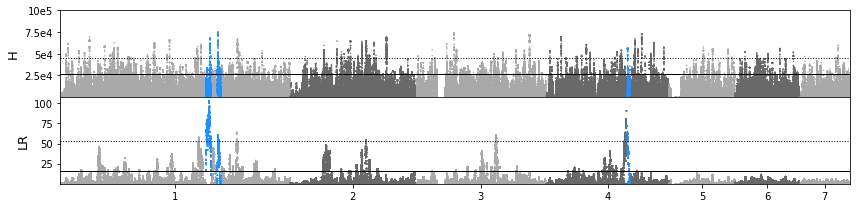

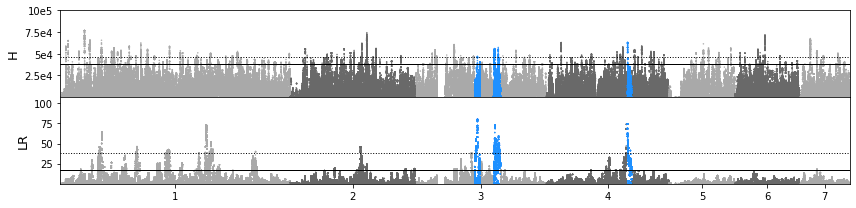

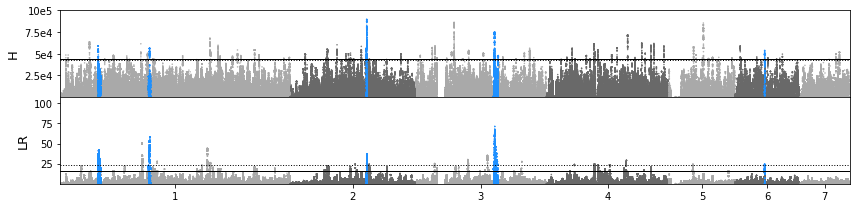

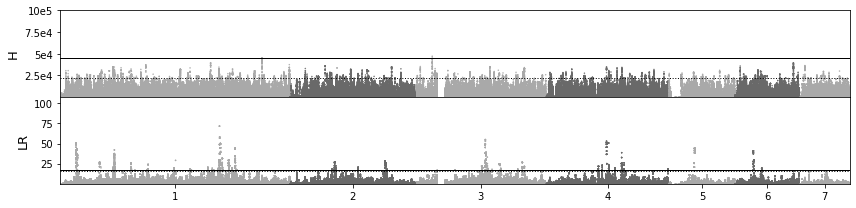

In [17]:
#for pop in ["brazil"]:
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(12, 3)) #gridspec_kw={'hspace': 0.1}

    sdf=dfs[pop].loc[dfs[pop]["target_region"] == True]
    ndf=dfs[pop].loc[dfs[pop]["target_region"] != True]
    
    #plot each seperatley (so the sig points are on top)
    axs[0].scatter(ndf["x_pos"], ndf["h"],         marker =".", s = 1, c = ndf['colors'])
    axs[1].scatter(ndf["x_pos"], ndf["lr"],        marker =".", s = 1, c = ndf['colors'])

    axs[0].scatter(sdf["x_pos"], sdf["h"],         marker =".", s = 1, c = sdf['colors'])
    axs[1].scatter(sdf["x_pos"], sdf["lr"],        marker =".", s = 1, c = sdf['colors'])

    #set axes
    plt.xlim(0, scanned_size)
    axs[0].set_ylim( (0, h_ylim*1.05) )
    axs[1].set_ylim( (0, lr_ylim*1.05) )
        
    tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
    plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

    axs[0].set_yticks(np.arange(25_000, 100_001, 25_000))
    axs[0].set_yticklabels(labels=["2.5e4", "5e4", "7.5e4", "10e5"])
    #axs[0].ticklabel_format(axis='y', style='sci')
    axs[0].set_ylabel("H", fontsize=13)

    
    axs[1].set_yticks(np.arange(25, 101, 25))
    axs[1].set_ylabel("LR", fontsize=13)

    #draw lines at...
    #...the max simulated value
    axs[0].axhline(y=max_h[pop],  color="black", linewidth=1)
    axs[1].axhline(y=max_lr[pop], color="black", linewidth=1)

    #...the 99th percentile
    target_percentile=0.99
    axs[0].axhline(y=np.percentile(dfs[pop]['h'],  target_percentile*100), linestyle=":", color="black", linewidth=1)
    axs[1].axhline(y=np.percentile(dfs[pop]['lr'], target_percentile*100), linestyle=":", color="black", linewidth=1)
    
    #set the title
    #title="{}".format(pop.title())
    #fig.suptitle(title)

    plt.tight_layout()
    fig.savefig("results/selection_peaks/{}_selection.png".format(pop), dpi=300)
    #fig.savefig("results/selection_peaks/{}_selection.svg".format(pop)) 
    plt.show()
    plt.close()

# Plot pcadapt

In [27]:
df=pd.read_csv("results/pcadapt/pcadapt.csv", sep=',')

for index, row in tqdm(df.iterrows()):
    color = colors[row["chrom"]]
    x=cumul_start[row["chrom"]] + row["pos"]

    if row["sigs"] == True:
        color=colors["sig"]

#     if row["comps"] == 1.:
#         color="red"
#     if row["comps"] == 2.:
#         color="blue"

    df.at[index,'colors']= color
    df.at[index,'x'] = x
    
df

21913it [00:01, 17154.17it/s]


,chrom,pos,stat,chi2,pval,padj,logp,sigs,comps,fst,het,colors,x
0,SM_V7_1,302288,1.707152,0.943859,0.623798,1.0,0.0,False,NaN,0.000213,0.499922,darkgrey,302288.0
1,SM_V7_1,705322,1.328624,0.734576,0.692610,1.0,0.0,False,NaN,0.001793,0.095000,darkgrey,705322.0
2,SM_V7_1,705340,2.049736,1.133268,0.567432,1.0,0.0,False,NaN,0.019065,0.117188,darkgrey,705340.0
3,SM_V7_1,1060362,0.923020,0.510324,0.774791,1.0,0.0,False,NaN,0.094908,0.409687,darkgrey,1060362.0
4,SM_V7_1,1060390,16.275058,8.998234,0.011119,1.0,0.0,False,NaN,0.073177,0.420000,darkgrey,1060390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21908,SM_V7_7,19000002,2.682516,1.483122,0.476370,1.0,0.0,False,NaN,0.358452,0.447188,darkgrey,303995209.0
21909,SM_V7_7,19000008,5.928768,3.277926,0.194181,1.0,0.0,False,NaN,0.501766,0.488750,darkgrey,303995215.0
21910,SM_V7_7,19009311,0.642314,0.355126,0.837308,1.0,0.0,False,NaN,0.046552,0.199687,darkgrey,304004518.0
21911,SM_V7_7,19009392,2.247127,1.242403,0.537299,1.0,0.0,False,NaN,0.010241,0.117188,darkgrey,304004599.0


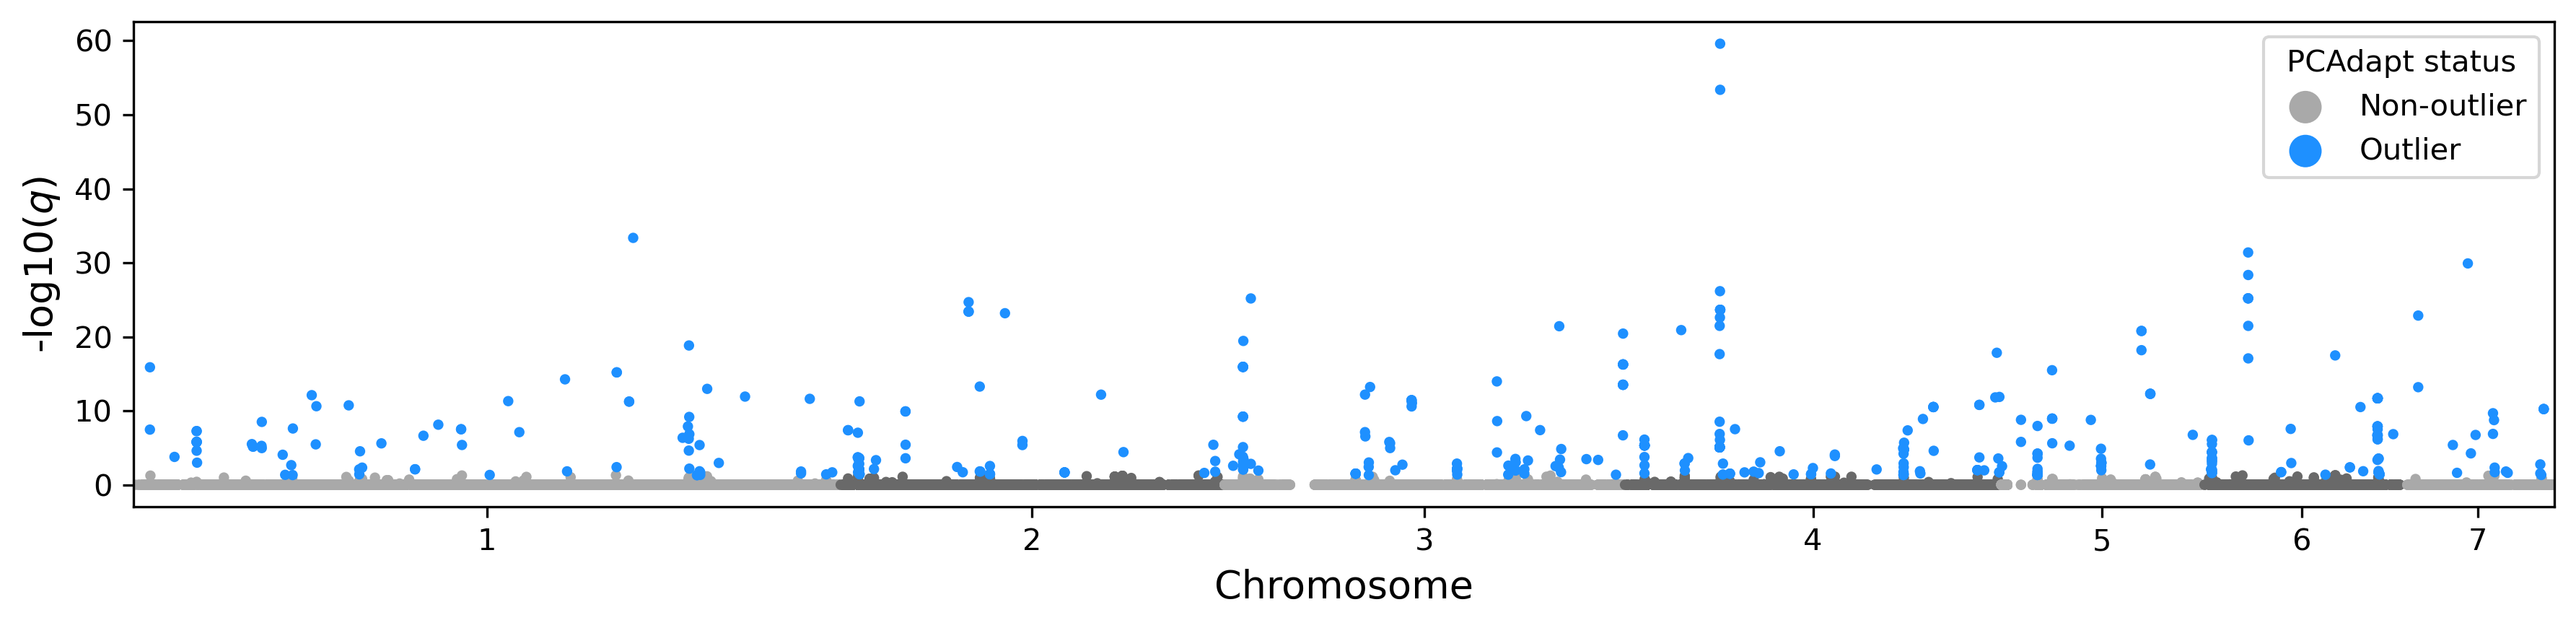

In [29]:
plt.figure(figsize=(12, 3), dpi=300)

csig=df.loc[np.isfinite(df["comps"])]
cNaN=df.loc[np.isnan(df["comps"])]

plt.scatter(cNaN["x"], cNaN["logp"], alpha=1, s=6, color=cNaN["colors"], label="Non-outlier")
plt.scatter(csig["x"], csig["logp"], alpha=1, s=6, color=csig["colors"], label="Outlier")


#set axes
plt.xlim(0, scanned_size)
#plt.ylim( (0, df["logp"].max()*1.05) )

plt.legend(title="PCAdapt status", markerscale=4)

tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.xticks(ticks, labels=list(range(1,8)))
plt.ylabel("-log10($\it{q}$)", fontsize=13)
plt.xlabel("Chromosome", fontsize=13)
#plt.yscale("log")

plt.tight_layout()
plt.savefig("results/selection_peaks/pcadapt.png", dpi=300)
#plt.savefig("results/selection_peaks/pcadapt.svg") 
plt.show()
plt.close()
    

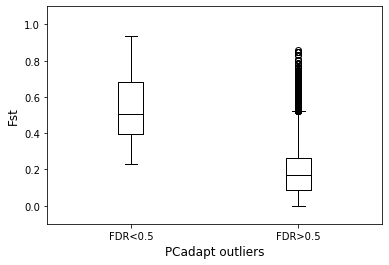

mean fst: pcadapt FDR<0.5 = 0.544095, FDR>0.5 = 0.195126


In [30]:
#fst of pcadapt sigs
sig=df.loc[df["sigs"]==True]["fst"]

#fst of pcadat insigs
insig=df.loc[df["sigs"]!=True]["fst"]

#plt.figure(figsize=(2, 2), dpi=300)
plt.boxplot([sig, insig],
            showfliers=True, 
            notch=False,
            labels=["FDR<0.5", "FDR>0.5"],
            medianprops=dict(color="black", lw=1))
plt.ylim(-0.1,1.1)
plt.xlabel("PCadapt outliers", fontsize=12)
plt.ylabel("Fst", fontsize=12)
plt.show()

print("mean fst: pcadapt FDR<0.5 = {:1f}, FDR>0.5 = {:1f}".format(sig.mean(), insig.mean()))

In [44]:
#intersect pcadapt with the target regions
df["stop"]=df["pos"] + 1
pca_bed=pybedtools.BedTool.from_dataframe(df[["chrom", "pos", "stop"]])

for pop in ["brazil", "tanzania", "niger", "senegal"]:
#for pop in ["brazil"]:
    t_regions_if   = "results/selection_peaks/{}_target_regions.bed".format(pop)
    target_regions = pybedtools.BedTool(t_regions_if)

    #intersect
    target_vs_pca_bed = target_regions.intersect(pca_bed, u=True)
    print(target_vs_pca_bed)

SM_V7_1	14832351	15772979
SM_V7_1	34234733	35105276
SM_V7_3	30092830	31936551
SM_V7_2	29220788	29604570
SM_V7_6	11468141	11631927


SM_V7_1	56295674	58355356
SM_V7_1	60733736	62145588
SM_V7_4	31216154	32138352

SM_V7_3	22786583	24999268
SM_V7_3	30092830	32970510
SM_V7_4	31216154	32881663



In [42]:
length=0
for bed_int in pca_bed:
    start = int(bed_int.start)
    stop = int(bed_int.stop)
    length += stop - start + 1
    
print(length/1_000_000)

280.168288


# Explore target regions

In [ ]:
dfs["brazil"]

In [30]:
with open('results/selection_peaks/peaks.bed', 'w') as outfile:
    for pop in ["niger", "senegal", "brazil", "tanzania"]:
        with open( "results/selection_peaks/{}_target_regions.bed".format(pop), 'r') as infile:
            for entry in infile:
                entry=entry.rstrip()
                outfile.write("{}\t{}\n".format(entry, pop))

sig_regions_bed = pybedtools.BedTool('results/selection_peaks/peaks.bed')
print(sig_regions_bed)

SM_V7_1	56295674	58355356	niger
SM_V7_1	60733736	62145588	niger
SM_V7_4	31216154	32138352	niger
SM_V7_3	22786583	24999268	senegal
SM_V7_3	30092830	32970510	senegal
SM_V7_4	31216154	32881663	senegal
SM_V7_1	14832351	15772979	brazil
SM_V7_1	34234733	35105276	brazil
SM_V7_3	30092830	31936551	brazil
SM_V7_2	29220788	29604570	brazil
SM_V7_6	11468141	11631927	brazil



In [31]:
#avg peak size 
size=0
for chrom, start, stop, pop in sig_regions_bed:
    size+=int(stop)-int(start)+1

avg_size=size/len(sig_regions_bed)

print("avg peak size is {:.1f} bp".format(avg_size))

avg peak size is 1395643.4 bp


In [102]:
genes={}
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    genes[pop] = dfs[pop].loc[(dfs[pop]["target_region"] == True), "gene"]
    genes[pop] = genes[pop][genes[pop].notnull()]
    genes[pop] = list(genes[pop].unique())
    print("{} has {} genes in target regions".format(pop, len(genes[pop])))
    

brazil has 116 genes in target regions
tanzania has 0 genes in target regions
niger has 112 genes in target regions
senegal has 157 genes in target regions


In [123]:
#write these genes to a file for a table
for pop in ["brazil", "tanzania", "niger", "senegal"]:

    with open("results/selection_peaks/{}_peak_genes".format(pop), 'w') as f:
        for gene in genes[pop]:
            f.write("{}\n".format(gene))

In [103]:
pop_combos=list(itertools.combinations(["brazil", "senegal", "niger"], 2)) 

for pop1, pop2 in pop_combos:
    
    shared_genes=set(genes[pop1]).intersection(set(genes[pop2]))
    shared_genes
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 48 genes, {'Smp_002880', 'Smp_308830', 'Smp_002740', 'Smp_300810', 'Smp_123450', 'Smp_164590', 'Smp_084540', 'Smp_123690', 'Smp_123630', 'Smp_123600', 'Smp_341880', 'Smp_337740', 'Smp_123440', 'Smp_123670', 'Smp_084520', 'Smp_164560', 'Smp_123500', 'Smp_347390', 'Smp_123610', 'Smp_002600', 'Smp_002510', 'Smp_123460', 'Smp_345510', 'Smp_123490', 'Smp_002820', 'Smp_021340', 'Smp_123530', 'Smp_002870', 'Smp_212320', 'Smp_002860', 'Smp_002920', 'Smp_123640', 'Smp_123620', 'Smp_123510', 'Smp_123480', 'Smp_123590', 'Smp_308820', 'Smp_165280', 'Smp_123470', 'Smp_202120', 'Smp_002640', 'Smp_123520', 'Smp_078730', 'Smp_002840', 'Smp_197370', 'Smp_078750', 'Smp_123570', 'Smp_002550'}
brazil v niger: 0 genes, set()
senegal v niger: 22 genes, {'Smp_095680', 'Smp_093850', 'Smp_095650', 'Smp_334280', 'Smp_093840', 'Smp_204980', 'Smp_180240', 'Smp_266770', 'Smp_174580', 'Smp_341620', 'Smp_345890', 'Smp_095630', 'Smp_114565', 'Smp_174630', 'Smp_174610', 'Smp_313490', 'Smp_167890', 'S

In [114]:
#how many genes wtih 99% SNVs
snv_genes={}

for pop in ["brazil", "tanzania", "niger", "senegal"]:
    snv_genes[pop] = dfs[pop].loc[(dfs[pop]["99p_h"] == True) &
                                  (dfs[pop]["99p_sf2"] == True) &
                                  (dfs[pop]["gt_sim_h"] == True) &
                                  (dfs[pop]["gt_sim_lr"] == True), "gene"]
    snv_genes[pop] = snv_genes[pop][snv_genes[pop].notnull()]
    snv_genes[pop] = list(snv_genes[pop].unique())
    print("{} has {} genes with target snvs: {}".format(pop, len(snv_genes[pop]), snv_genes[pop]))

brazil has 10 genes with target snvs: ['Smp_073680', 'Smp_162000', 'Smp_060090', 'Smp_246630', 'Smp_123510', 'Smp_123520', 'Smp_123570', 'Smp_123590', 'Smp_148460', 'Smp_341570']
tanzania has 0 genes with target snvs: []
niger has 5 genes with target snvs: ['Smp_008230', 'Smp_126620', 'Smp_165060', 'Smp_167890', 'Smp_313490']
senegal has 7 genes with target snvs: ['Smp_070780', 'Smp_123440', 'Smp_123520', 'Smp_164560', 'Smp_213150', 'Smp_167890', 'Smp_313490']


In [113]:
pop_combos=list(itertools.combinations(["brazil", "senegal", "niger"], 2)) 

for pop1, pop2 in pop_combos:
    
    shared_genes=set(snv_genes[pop1]).intersection(set(snv_genes[pop2]))
    shared_genes
    print("{} v {}: {} genes, {}".format(pop1, 
                                         pop2, 
                                         str(len(shared_genes)), 
                                         str(shared_genes)))

brazil v senegal: 1 genes, {'Smp_123520'}
brazil v niger: 0 genes, set()
senegal v niger: 2 genes, {'Smp_313490', 'Smp_167890'}


# Pi vs target regions

In [ ]:
#read in data
dfs={}
for pop in tqdm(['brazil', 'niger',  'senegal', 'tanzania']):
    dfs[pop]=pd.read_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.58it/s]


In [ ]:
pi_dfs={}
for pop in tqdm(['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']):
    pi_dfs[pop]=pd.read_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop),sep=",").dropna(subset=["pi"])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 112.47it/s]


In [ ]:
for pop in ['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']:
    pi=pi_dfs[pop]["pi"].dropna().mean()
    print("{}: {}".format(pop, pi))

brazil: 0.0006925911327382877
niger: 0.0005997772684642776
senegal: 0.0004968465614561425
tanzania: 0.0014511327938964362
caribbean: 0.0006274731680908758
rodhaini: 0.0005606783152180918


In [ ]:
#get sig regions and calculate pi in vs out of those regions
regions_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
regions_df.columns=["chrom", "start", "stop", "pop"]


region_trees=defaultdict(lambda: defaultdict( lambda: IntervalTree()))

for index, row in regions_df.iterrows():
    pop=row["pop"]
    chrom=row["chrom"]
    start=row["start"]
    stop=row["stop"]
    region_trees[pop][chrom][start : stop] = "significant"

In [ ]:
sig_pis=defaultdict(lambda: [])
nsig_pis=defaultdict(lambda: [])
sig_pi_df=pd.DataFrame(columns=list(pi_dfs["brazil"].columns) + ["pop"])

#now for each pi subset if it is in the tree or not
for pop in ['brazil', 'niger',  'senegal', 'tanzania', 'caribbean', 'rodhaini']:

    df=pi_dfs[pop]
    
    for index, row in df.iterrows():
        pi=row["pi"]
        chrom=row["chrom"]
        start=row["start"]
        stop=row["stop"]
        row["pop"] = pop
        
        if region_trees[pop][chrom][start : stop] == set():
            nsig_pis[pop].append(pi)
        else:
            sig_pis[pop].append(pi)
            sig_pi_df=sig_df.append(row)

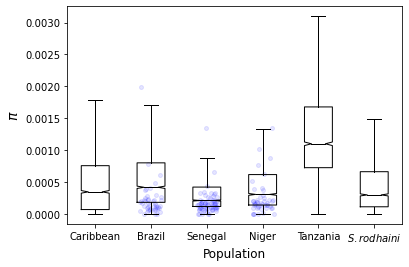

In [ ]:
x_pos={"caribbean" : 1,
       "brazil"    : 2,
       "senegal"   : 3,
       "niger"     : 4,
       "tanzania"  : 5,
       "rodhaini"  : 6 }

for index, row in sig_pi_df.iterrows():
    x=x_pos[row["pop"]]
    y=row["pi"]
    
    #add jitter
    x=x+random.uniform(-0.2, 0.2)
    
    plt.plot(x, y, 'b.', markersize=8, alpha=0.1)
    
plt.boxplot([ pi_dfs["caribbean"].dropna(subset=["pi"])["pi"],
              pi_dfs["brazil"].dropna(subset=["pi"])["pi"],
              pi_dfs["senegal"].dropna(subset=["pi"])["pi"],
              pi_dfs["niger"].dropna(subset=["pi"])["pi"], 
              pi_dfs["tanzania"].dropna(subset=["pi"])["pi"],
              pi_dfs["rodhaini"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
             medianprops=dict(color="black", lw=1) )

plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
#plt.yscale("log")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsig.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigs.png", dpi=300)
plt.show()

In [219]:
stats.ttest_ind(pi_dfs["brazil"]["pi"].dropna(), pi_dfs["niger"]["pi"].dropna(), equal_var=False)

Ttest_indResult(statistic=3.228200870883685, pvalue=0.0012528051590282789)

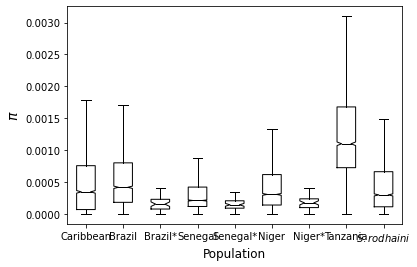

In [ ]:
plt.boxplot([ pi_dfs["caribbean"].dropna(subset=["pi"])["pi"],
              pi_dfs["brazil"].dropna(subset=["pi"])["pi"],
              sig_pi_df.loc[sig_pi_df["pop"] == "brazil"]["pi"],
              pi_dfs["senegal"].dropna(subset=["pi"])["pi"],
              sig_pi_df.loc[sig_pi_df["pop"] == "senegal"]["pi"],
              pi_dfs["niger"].dropna(subset=["pi"])["pi"], 
              sig_pi_df.loc[sig_pi_df["pop"] == "niger"]["pi"],
              pi_dfs["tanzania"].dropna(subset=["pi"])["pi"],
              pi_dfs["rodhaini"].dropna(subset=["pi"])["pi"] ],
             showfliers=False, 
             notch=True,
             labels=["Caribbean", "Brazil", "Brazil*", "Senegal", "Senegal*", "Niger", "Niger*", "Tanzania", "$\it{S. rodhaini}$"],
             medianprops=dict(color="black", lw=1) )

plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
#plt.yscale("log")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigboxes.svg")
#plt.savefig("results/pi/pi_boxplot_100kb_windows_wsigboxes.png", dpi=300)
plt.show()

In [ ]:
print("pop, all_pi_mean, sig_pi_mean, t, p")
    
for pop in ["brazil", "niger", "senegal"]:
    spi=sig_pi_df.loc[sig_pi_df["pop"] == pop]["pi"]
    api=pi_dfs[].dropna(subset=["pi"])["pi"]
    t, p = stats.ttest_ind(spi, api, equal_var=False)
    
    
    print("{}, {}, {}, {}, {}".format(pop,
                                      api.mean(),
                                      spi.mean(),
                                      t,
                                      p) )

pop, all_pi_mean, sig_pi_mean, t, p
brazil, 0.0006925911327382877, 0.00022224333460848123, -9.416231788772604, 8.938591091307505e-14
niger, 0.0005997772684642776, 0.00024586149501158033, -7.91917194086271, 2.1397008531879e-11
senegal, 0.0004968465614561425, 0.00017477014772342917, -11.184868001573586, 3.436892382982485e-23


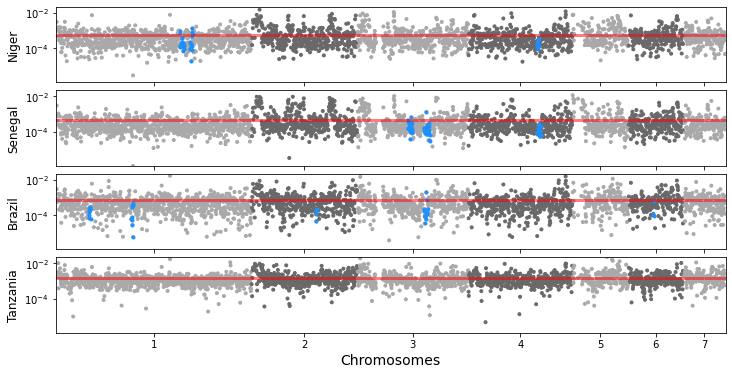

In [ ]:
#get ylims from pis
pis=np.array([])
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    pis=np.append(pis, pi_dfs[pop]["pi"])
    
min_pi=pis[pis>0].min()
max_pi=pis[pis>0].max()

#set up figure
fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

#plot scatter for pi and each pop
i=0
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    ########################
    # normal pi
    ########################
    #add info for figure including x position and the point color
    cs=[]
    xs=[]
    for index, row in pi_dfs[pop].iterrows():
        pos=(row["start"] + row["stop"])/2
        cs.append(colors[row["chrom"]])
        xs.append(cumul_start[row["chrom"]] + pos)

    #get data without missing values
    pis=pi_dfs[pop]["pi"]
    
    #plot
    axs[i].scatter(xs, pis, marker =".", c = cs)

    #add line at mean pi
    axs[i].axhline(y=pis.mean(), xmin=0, xmax=scanned_size, color="red", linewidth=3, alpha=0.5)
    
    
    ########################
    # sig pi
    ########################
    xs=[]
    spi_df=sig_pi_df.loc[sig_pi_df["pop"] == pop]
    
    for index, row in spi_df.iterrows():
        pos=(row["start"] + row["stop"])/2
        xs.append(cumul_start[row["chrom"]] + pos)
        
    spis=spi_df["pi"]
    axs[i].scatter(xs, spis, marker =".", c = "dodgerblue")
               
    #make the axis labeling
    axs[i].set_ylabel("{}".format(pop.title()), fontsize=12)
    axs[i].set_yscale('log')
    axs[i].set_ylim(min_pi,max_pi)
   
    #increment to the next population (and subplot)
    i=i+1
    
# #add tick 
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

# #set xlims
plt.xlim(0, scanned_size)
plt.xlabel("Chromosomes", fontsize=14)

# #set the title
title="$\pi$"
#fig.suptitle(title, fontsize=14)
    
# #plt.tight_layout()

fig.savefig("results/selection_peaks/pi_across_the_genome.png".format(pop), dpi=300)
# #fig.savefig("results/selection_peaks/pi_across_the_genome.svg".format(pop)) 
plt.show()
plt.close()

In [ ]:
# compare sig regions to same regions in west africa and other pops

In [ ]:
#get pis
pi_dfs={}
pi_trees=defaultdict(lambda: defaultdict( lambda: IntervalTree()))

for pop in ["brazil", "tanzania", "niger", "senegal"]:
    pi_dfs[pop]=pi_dfs[pop]=pd.read_csv("results/pi/pi_boxplot_100kb_windows_{}.csv".format(pop),sep=",")

    for index, row in pi_dfs[pop].iterrows():
        chrom=row["chrom"]
        start=row["start"]
        stop=row["stop"]
        pi=row["pi"]
        pi_trees[pop][chrom][start : stop] = pi
        
#get sig regions
regions_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
regions_df.columns=["chrom", "start", "stop", "pop"]


region_trees=defaultdict(lambda: defaultdict( lambda: IntervalTree()))
for index, row in regions_df.iterrows():
    pop=row["pop"]
    chrom=row["chrom"]
    start=row["start"]
    stop=row["stop"]
    region_trees[pop][chrom][start : stop] = "significant"

In [ ]:
for interval in region_trees["brazil"]["SM_V7_1"].items():
    start = interval.begin
    end = interval.end
    
    pi_trees[pop][chrom]

35105276
15772979


In [ ]:
bpis=np.array([])
tpis=np.array([])
npis=np.array([])
spis=np.array([])

for i in pi_trees["brazil"][chrom].envelop(start, end):
    bpis=np.append(bpis, i.data)
    
for i in pi_trees["tanzania"][chrom].envelop(start, end):
    tpis=np.append(bpis, i.data)

for i in pi_trees["senegal"][chrom].envelop(start, end):
    spis=np.append(bpis, i.data)
 
for i in pi_trees["niger"][chrom].envelop(start, end):
    npis=np.append(bpis, i.data)

    
bpis.mean()

0.0019979792144594107

In [ ]:
tpis.mean()

0.0019069508957296427

In [ ]:
spis.mean()

0.0017913589929698208

In [ ]:
npis.mean()

0.002114217287337532

# Tajima's D Genome vs target regions

In [578]:
#read in data
dfs={}
for pop in tqdm(['brazil', 'niger',  'senegal', 'tanzania']):
    dfs[pop]=pd.read_csv("results/selection_peaks/to_plot_{}.csv".format(pop), sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.28s/it]


In [579]:
td_dfs={}
for pop in tqdm(['rodhaini', 'caribbean', 'brazil', 'niger',  'senegal', 'tanzania']):
    td_dfs[pop] = pd.read_csv("results/tajimas_d/tajimas_d_boxplot_100kb_windows_{}.csv".format(pop), sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 54.34it/s]


In [581]:
#get sig regions and calculate pi in vs out of those regions
regions_df = pd.read_table('results/selection_peaks/peaks.bed', sep="\t", header=None)
regions_df.columns=["chrom", "start", "stop", "pop"]


region_trees=defaultdict(lambda: defaultdict( lambda: IntervalTree()))

for index, row in regions_df.iterrows():
    pop=row["pop"]
    chrom=row["chrom"]
    start=row["start"]
    stop=row["stop"]
    region_trees[pop][chrom][start : stop] = "significant"

In [600]:
sig_tds=defaultdict(lambda: [])
nsig_tds=defaultdict(lambda: [])
sig_td_df=pd.DataFrame(columns=list(td_dfs["brazil"].columns) + ["pop"])

In [618]:
sig_tds=defaultdict(lambda: [])
nsig_tds=defaultdict(lambda: [])
sig_td_df=pd.DataFrame(columns=list(td_dfs["brazil"].columns) + ["pop"])

#now for each td subset if it is in the tree or not
for pop in ['rodhaini', 'niger',  'senegal', 'tanzania', 'caribbean', 'brazil']:
#for pop in ["brazil"]:  
    for index, row in tqdm(td_dfs[pop].iterrows()):
        td=row["tajimas_d"]
        chrom=row["chrom"]
        start=row["start"]
        stop=row["stop"]
        row["pop"] = pop
        
        if region_trees[pop][chrom][start : stop] == set():
            nsig_tds[pop].append(td)
        else:
            sig_tds[pop].append(td)
            sig_td_df=sig_td_df.append(row)

3025it [00:02, 1161.26it/s]
3025it [00:02, 1132.70it/s]
3025it [00:02, 1050.08it/s]
3025it [00:02, 1046.44it/s]
3025it [00:02, 1322.24it/s]
3025it [00:02, 1138.58it/s]


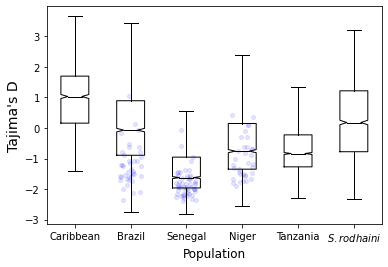

In [619]:
x_pos={"caribbean" : 1,
       "brazil"    : 2,
       "senegal"   : 3,
       "niger"     : 4,
       "tanzania"  : 5,
       "rodhaini"  : 6 }

for index, row in sig_td_df.iterrows():
    x=x_pos[row["pop"]]
    y=row["tajimas_d"]
    
    #add jitter
    x=x+random.uniform(-0.2, 0.2)
    
    plt.plot(x, y, 'b.', markersize=8, alpha=0.1)
    
plt.boxplot([ td_dfs["caribbean"].dropna(subset=["tajimas_d"])["tajimas_d"],
              td_dfs["brazil"].dropna(subset=["tajimas_d"])["tajimas_d"],
              td_dfs["senegal"].dropna(subset=["tajimas_d"])["tajimas_d"],
              td_dfs["niger"].dropna(subset=["tajimas_d"])["tajimas_d"], 
              td_dfs["tanzania"].dropna(subset=["tajimas_d"])["tajimas_d"],
              td_dfs["rodhaini"].dropna(subset=["tajimas_d"])["tajimas_d"] ],
              showfliers=False, 
              notch=True,
              labels=["Caribbean", "Brazil", "Senegal", "Niger", "Tanzania", "$\it{S. rodhaini}$"],
              medianprops=dict(color="black", lw=1) )

plt.xlabel("Population", fontsize=12)
plt.ylabel("Tajima's D", fontsize=14)
#plt.yscale("log")
plt.savefig("results/tajimas_d/td_boxplot_100kb_windows_wsig.svg")
plt.savefig("results/tajimas_d/td_boxplot_100kb_windows_wsigs.png", dpi=300)
plt.show()

In [627]:
print("pop, all_td_mean, sig_td_mean, t, p")
    
for pop in ["brazil", "niger", "senegal"]:
    std=sig_td_df.loc[sig_td_df["pop"] == pop]["tajimas_d"].dropna()
    atd=td_dfs[pop].dropna(subset=["tajimas_d"])["tajimas_d"].dropna()
    t, p = stats.ttest_ind(std, atd, equal_var=False)
    
    
    print("{}, {}, {}, {}, {}".format(pop,
                                      atd.mean(),
                                      std.mean(),
                                      t,
                                      p) )

pop, all_td_mean, sig_td_mean, t, p
brazil, 0.06684858730628619, -1.2184994930224922, -11.631728290610418, 9.144153153111027e-15
niger, -0.5409664002990417, -1.0175734002804615, -4.110562636654066, 0.0002204008953422628
senegal, -1.3106375120235756, -1.8162021706762341, -8.116869911624999, 1.6683259844239767e-11


In [631]:
#td reduction in brazilin regions
-1.2184994930224922/0.06684858730628619

-18.227752329897164

In [576]:
#get ylims from pis
tds=np.array([])
for pop in ["brazil", "tanzania", "niger", "senegal"]:
    tds=np.append(tds, td_dfs[pop]["tajimas_d"])
    
min_td=tds[np.isfinite(tds)].min()
max_td=tds[np.isfinite(tds)].max()

plot_lim=max(abs(min_td),max_td)

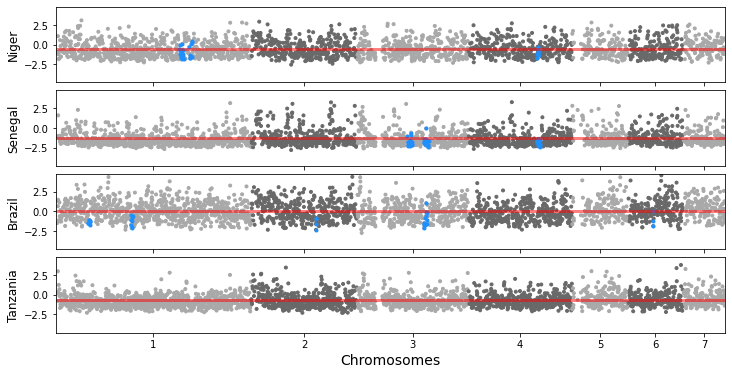

In [622]:
#set up figure
fig, axs = plt.subplots(4, sharex=True, gridspec_kw={'hspace': 0.1}, figsize=(12, 6)) #gridspec_kw={'hspace': 0.1}

#plot scatter for pi and each pop
i=0
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    ########################
    # normal td
    ########################
    #add info for figure including x position and the point color
    cs=[]
    xs=[]
    for index, row in td_dfs[pop].iterrows():
        pos=(row["start"] + row["stop"])/2
        cs.append(colors[row["chrom"]])
        xs.append(cumul_start[row["chrom"]] + pos)

    #get data without missing values
    tds=td_dfs[pop]["tajimas_d"]
    
    #plot
    axs[i].scatter(xs, tds, marker =".", c = cs)

    #add line at mean pi
    axs[i].axhline(y=tds.mean(), xmin=0, xmax=scanned_size, color="red", linewidth=3, alpha=0.5)
    
    
    ########################
    # sig pi
    ########################
    xs=[]
    std_df=sig_td_df.loc[sig_td_df["pop"] == pop]
    
    for index, row in std_df.iterrows():
        pos=(row["start"] + row["stop"])/2
        xs.append(cumul_start[row["chrom"]] + pos)
        
    stds=std_df["tajimas_d"]
    axs[i].scatter(xs, stds, marker =".", c = "dodgerblue")
               
    #make the axis labeling
    axs[i].set_ylabel("{}".format(pop.title()), fontsize=12)
    #axs[i].set_yscale('log')
    axs[i].set_ylim(-plot_lim*1.05, plot_lim*1.05)
   
    #increment to the next population (and subplot)
    i=i+1
    
# #add tick 
tick_lbls = [ "1", "2", "3", "4", "5", "6" ,"7"]
plt.setp(axs, xticks=ticks, xticklabels=tick_lbls)

# #set xlims
plt.xlim(0, scanned_size)
plt.xlabel("Chromosomes", fontsize=14)

# #set the title
title="Tajima's D"
#fig.suptitle(title, fontsize=14)
    
# #plt.tight_layout()

fig.savefig("results/selection_peaks/tajimasd_across_the_genome.png".format(pop), dpi=300)
# #fig.savefig("results/selection_peaks/tajimasd_across_the_genome.svg".format(pop)) 
plt.show()
plt.close()

# Make big table

In [18]:
Path("results/all_genes_table").mkdir(parents=True, exist_ok=True)

In [25]:
for pop in ["niger", "senegal", "brazil", "tanzania"]:

    dfs[pop]["99p_h"] = False 
    dfs[pop].loc[dfs[pop]["h_prank"] > 0.99, "99p_h"] = True

    dfs[pop]["99p_sf2"] = False 
    dfs[pop].loc[dfs[pop]["lr_prank"] > 0.99, "99p_sf2"] = True

    dfs[pop]["pca_fdr"] = False 
    dfs[pop].loc[dfs[pop]["pcadapt-padj"] > 0.95, "pca_fdr"] = True

    dfs[pop]["gt_sim_h"] = False 
    dfs[pop].loc[dfs[pop]["h"] > max_h[pop], "gt_sim_h"] = True
    
    dfs[pop]["gt_sim_lr"] = False 
    dfs[pop].loc[dfs[pop]["lr"] > max_lr[pop], "gt_sim_lr"] = True
    
    
    dfs[pop]["pop"] = pop

#concat dfs
df=pd.concat( [dfs["brazil"], dfs["senegal"], dfs["niger"], dfs["tanzania"]]) 
df = df.replace("brazil", "Brazil")
df = df.replace("senegal", "Senegal")
df = df.replace("niger", "Niger")
df = df.replace("tanzania", "Tanzania")
df.replace("SM_V7_", "", regex=True)

df=df.drop(["h", "lr", "pi", "tajimas_d", "pcadapt-padj", "h_prank", "lr_prank", "colors", "x_pos"], axis='columns')

col_order = ['chrom', 'pos', 'gene', 'pop', 'gt_sim_h', 'gt_sim_lr', '99p_h', '99p_sf2', 'pca_fdr', 'non-neutral_region', 'target_region']
df = df[col_order]
df.columns=["Chrom", "Pos", "Gene", "Population", "> Simulated H", "> Simulated LR", "99th percentile H", "99th percentile Sf2", "FDR < 0.5 pcadapt", "Non-neutral region", "Putative region of selection"]


df = df.loc[ (df["> Simulated H"]                == True) |
             (df["> Simulated LR"]               == True) |
             (df["99th percentile H"]            == True) |
             (df["99th percentile Sf2"]          == True) |
             (df["FDR < 0.5 pcadapt"]            == True) |
             (df["Non-neutral region"]           == True) |
             (df["Putative region of selection"] == True)  ]

df.to_csv("results/all_genes_table/all_genes_test.csv", sep=",", index=False, na_rep='NULL')

df

,Chrom,Pos,Gene,Population,> Simulated H,> Simulated LR,99th percentile H,99th percentile Sf2,FDR < 0.5 pcadapt,Non-neutral region,Putative region of selection
580,SM_V7_1,2355585,Smp_346460,Brazil,True,False,True,False,False,True,False
581,SM_V7_1,2364807,Smp_346460,Brazil,True,False,True,False,False,True,False
1334,SM_V7_1,3252525,Smp_241980,Brazil,True,False,True,False,False,True,False
1335,SM_V7_1,3252531,Smp_241980,Brazil,True,False,True,False,False,True,False
1336,SM_V7_1,3252536,Smp_241980,Brazil,True,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
470522,SM_V7_7,15406000,Smp_125160,Tanzania,False,False,True,False,False,False,False
470523,SM_V7_7,15406001,Smp_125160,Tanzania,False,False,True,False,False,False,False
470524,SM_V7_7,15406004,Smp_125160,Tanzania,False,False,True,False,False,False,False
470525,SM_V7_7,15406007,Smp_125160,Tanzania,False,False,True,False,False,False,False


# Venn diagrams

In [ ]:
if not os.path.exists("results/venn_diagram"):
    os.mkdir("results/venn_diagram")

In [ ]:
dfs={}
for pop in ["senegal", "niger", "tanzania", "brazil"]:
    dfs[pop] = pd.read_csv("results/selection_peaks/mod_scores_{}.csv".format(pop), sep=",")

In [ ]:
pca_df=pd.read_csv("results/pcadapt/pcadapt.csv", sep=',')
pca_df["stop"]=pca_df["pos"] + 1
pca_bed=pybedtools.BedTool.from_dataframe(pca_df[["chrom", "pos", "stop"]]).merge(d=333_333)

print(x)
# pybedtools.BedTool.from_dataframe(sf2_df).merge(d=buffer)

SM_V7_1	302288	302289
SM_V7_1	705322	705341
SM_V7_1	1060362	5627306
SM_V7_1	6241828	16350561
SM_V7_1	16736862	88773604
SM_V7_2	22229	1563983
SM_V7_2	2171947	2573138
SM_V7_2	3048026	3671975
SM_V7_2	4201982	8454787
SM_V7_2	8788792	24584949
SM_V7_2	25060026	40611165
SM_V7_2	41194257	41264839
SM_V7_2	41663478	47983713
SM_V7_3	153752	8368173
SM_V7_3	11467592	13445943
SM_V7_3	13839562	27472285
SM_V7_3	27843917	29889484
SM_V7_3	30347808	32482293
SM_V7_3	33005550	36088503
SM_V7_3	36481442	38269253
SM_V7_3	38653785	46255733
SM_V7_3	47019293	47931761
SM_V7_3	48271210	50296048
SM_V7_4	11147	2779424
SM_V7_4	3529453	6413276
SM_V7_4	6913660	18931646
SM_V7_4	19389748	19458796
SM_V7_4	19828399	30526148
SM_V7_4	31356690	47152822
SM_V7_5	34063	768284
SM_V7_5	2498018	2498423
SM_V7_5	3966756	3966818
SM_V7_5	4425341	5012335
SM_V7_5	5665145	9311697
SM_V7_5	9671021	21885075
SM_V7_5	22327266	25142698
SM_V7_6	327310	327348
SM_V7_6	856715	23136333
SM_V7_6	23660876	24861931
SM_V7_7	808163	13868221
SM_V7_7	143026

In [ ]:
from matplotlib_venn import venn3

pop="brazil"

#set up output file names
sf2_bed_of = "results/venn_diagram/{}_non-neutral_sweepfinder_regions.bed".format(pop)
h_bed_of   = "results/venn_diagram/{}_non-neutral_hscan_regions.bed".format(pop)
pca_if     = "results/pcadapt/pcadapt.bed"

#get non-neutral snvs
sf2_df = dfs[pop].loc[ dfs[pop]["lr"]  > max_lr[pop] ]
h_df   = dfs[pop].loc[ dfs[pop]["h"]  > max_h[pop] ]

#convert to sweepfinder2 to bed
sf2_df["stop"] = sf2_df["pos"] + 1
sf2_df         = sf2_df[["chrom", "pos", "stop"]]
sf2_bed        = pybedtools.BedTool.from_dataframe(sf2_df).merge(d=buffer)
sf2_bed.saveas(sf2_bed_of)

#convert h-scan to bed
h_df["stop"] = h_df["pos"] + 1
h_df         = h_df[["chrom", "pos", "stop"]]
h_bed        = pybedtools.BedTool.from_dataframe(h_df).merge(d=buffer)
h_bed.saveas(h_bed_of)

#convert pcadapt to bed
#pca_bed = pybedtools.BedTool(pca_if)

# venn3([h_bed, sf2_bed, pca_bed], ('H-scan', 'Sweepfinder2', 'pcadapt'))
# plt.show()
    
pybedtools.contrib.venn_maker.venn_maker([sf2_bed, h_bed, pca_bed], 
                                         names=["sf2", "h", "pcadapt"], 
                                         figure_filename="results/venn_diagram/{}.svg".format(pop), 
                                         script_filename="results/venn_diagram/{}.R".format(pop), 
                                         additional_args=['fill=c("red","blue", "yellow")', 
                                                          'category.names = c("sf2" , "h" , "pca")',
                                                          'imagetype="svg"', 
                                                          'height = 480', 
                                                          'width = 480', 
                                                          'resolution = 300',
                                                          'compression = "lzw"',
                                                          'lwd = 1',
                                                          'lty = "blank"',
                                                          'cex = .6',
                                                          'fontface = "bold"',
                                                          'fontfamily = "sans"',
                                                          'cat.cex = 0.6',
                                                          'cat.fontface = "bold"',
                                                          'cat.default.pos = "outer"',
                                                          'cat.pos = c(-27, 27, 135)',
                                                          'cat.dist = c(0.055, 0.055, 0.085)',
                                                          'cat.fontfamily = "sans"',
                                                          'rotation = 1'], 
                                         run=True)


/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/master/nplatt/sch_man_nwinvasion/envs/sch_man_nwinvasion-selection/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


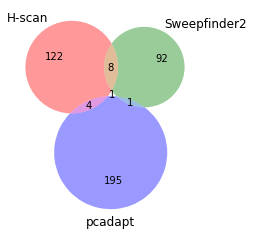

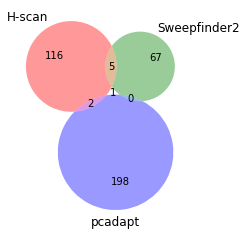

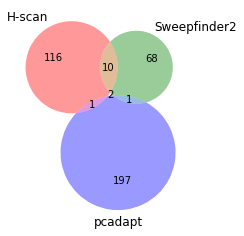

In [ ]:
for pop in ["senegal", "niger", "brazil"]:

    h_genes  = set(df.loc[ (df["Population"] == pop.title()) & (df["> simulated H"]  == True) & (df["99th percentile H"]  == True)]["Gene"])
    lr_genes = set(df.loc[ (df["Population"] == pop.title()) & (df["> simulated LR"] == True) & (df["99th percentile LR"] == True)]["Gene"])
    pc_genes = set(df.loc[ (df["Population"] == pop.title()) & (df["FDR < 0.5 pcadapt"] == True)]["Gene"])

    venn3([h_genes, lr_genes, pc_genes], ('H-scan', 'Sweepfinder2', 'pcadapt'))
    plt.show()

In [ ]:
pop.title()

'Brazil'

In [ ]:
chroms = list(dfs[pop]["chrom_x"])
poss =  list(dfs[pop]["pos_x"])
gt_sim_h = list(dfs[pop]["h"] > max_h[pop])
gt_sim_lr = list(dfs[pop]["h_perc_rank"] > 0.99)
gt_99p_h = list(dfs[pop]["lr"] > max_lr[pop])
gt_99p_lr = list(dfs[pop]["lr_perc_rank"] > 0.99)
sig_pc = list(dfs[pop]["sigs"])
genes = list(dfs[pop]["gene"])
pops=[pop] * len(dfs[pop])

sig_dfs[pop]=pd.DataFrame( data    = [chroms, poss, genes, pops, gt_sim_h, gt_99p_h, gt_sim_lr, gt_99p_lr, sig_pc]).T
sig_dfs[pop].columns=["chrom", "pos", "gene", "pop", "gt_sim_h", "gt_99p_h", "gt_sim_lr", "gt_99p_lr", "sig_pcadapt"]

sig_dfs[pop].loc[ (sig_dfs[pop]["gt_sim_h"]    ==True) |
                  (sig_dfs[pop]["gt_99p_h"]    ==True) |
                  (sig_dfs[pop]["gt_sim_lr"]   ==True) |
                  (sig_dfs[pop]["gt_99p_lr"]   ==True) |
                  (sig_dfs[pop]["sig_pcadapt"] ==True)  ]
                

,chrom,pos,gene,pop,gt_sim_h,gt_99p_h,gt_sim_lr,gt_99p_lr,sig_pcadapt
243,SM_V7_1,2079543,Smp_242000,brazil,False,False,False,False,True
272,SM_V7_1,2084612,Smp_078490,brazil,False,False,False,False,True
580,SM_V7_1,2355585,Smp_346460,brazil,True,False,True,False,NaN
581,SM_V7_1,2364807,Smp_346460,brazil,True,False,True,False,NaN
1334,SM_V7_1,3252525,Smp_241980,brazil,True,False,True,False,NaN
...,...,...,...,...,...,...,...,...,...
476908,SM_V7_7,17522345,Smp_031690,brazil,False,False,False,False,True
476981,SM_V7_7,17649057,Smp_139360,brazil,False,False,False,False,True
477261,SM_V7_7,17950592,Smp_343310,brazil,False,False,False,False,True
477266,SM_V7_7,17952669,Smp_343310,brazil,False,False,False,False,True


In [ ]:
df=[]

In [ ]:
[genes, pops, gt_sim_h, gt_99p_h, gt_sim_lr, gt_99p_lr, sig_pc]

In [ ]:
pops

['brazil', 'brazil', 'brazil', 'brazil']

In [ ]:
pcadapt_df = pd.read_csv("results/pcadapt/pcadapt.csv")

var_ids=[]
for index, row in pcadapt_df.iterrows():
        i = row["chrom"]
        j = row["pos"]
        var_id="{}:{}".format(i, j)
        var_ids.append(var_id)
        
pcadapt_df["var_id"] = var_ids
pcadapt_df

,chrom,pos,stat,chi2,pval,padj,logp,sigs,comps,fst,het,var_id
0,SM_V7_1,302288,1.707152,0.943859,0.623798,1.0,0.0,False,NaN,0.000213,0.499922,SM_V7_1:302288
1,SM_V7_1,705322,1.328624,0.734576,0.692610,1.0,0.0,False,NaN,0.001793,0.095000,SM_V7_1:705322
2,SM_V7_1,705340,2.049736,1.133268,0.567432,1.0,0.0,False,NaN,0.019065,0.117188,SM_V7_1:705340
3,SM_V7_1,1060362,0.923020,0.510324,0.774791,1.0,0.0,False,NaN,0.094908,0.409687,SM_V7_1:1060362
4,SM_V7_1,1060390,16.275058,8.998234,0.011119,1.0,0.0,False,NaN,0.073177,0.420000,SM_V7_1:1060390
...,...,...,...,...,...,...,...,...,...,...,...,...
21908,SM_V7_7,19000002,2.682516,1.483122,0.476370,1.0,0.0,False,NaN,0.358452,0.447188,SM_V7_7:19000002
21909,SM_V7_7,19000008,5.928768,3.277926,0.194181,1.0,0.0,False,NaN,0.501766,0.488750,SM_V7_7:19000008
21910,SM_V7_7,19009311,0.642314,0.355126,0.837308,1.0,0.0,False,NaN,0.046552,0.199687,SM_V7_7:19009311
21911,SM_V7_7,19009392,2.247127,1.242403,0.537299,1.0,0.0,False,NaN,0.010241,0.117188,SM_V7_7:19009392


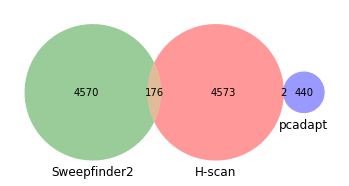

In [ ]:
pop="senegal"
h_set = set(dfs[pop].loc[ ( (dfs[pop]["h"]  > max_h[pop]) & 
                        (dfs[pop]["h_perc_rank"] >0.99) ) ]["var_id"])
             
             
lr_set = set(dfs[pop].loc[ ( ( dfs[pop]["lr"] > max_lr[pop]) & 
                         (dfs[pop]["lr_perc_rank"] >0.99 ) ) ]["var_id"])

pc_set = set(pcadapt_df.loc[pcadapt_df["sigs"] == True]["var_id"])

venn3([h_set, lr_set, pc_set], ('H-scan', 'Sweepfinder2', 'pcadapt'))
plt.show()

In [ ]:
pc_set.intersection(h_set)

set()

In [ ]:
pcadapt_df.loc[pcadapt_df["sigs"] == True]["var_id"]

35        SM_V7_1:2079543
36        SM_V7_1:2084612
191       SM_V7_1:5169021
290       SM_V7_1:7951555
291       SM_V7_1:7951620
               ...       
21835    SM_V7_7:17522345
21836    SM_V7_7:17649057
21845    SM_V7_7:17950592
21846    SM_V7_7:17952669
21847    SM_V7_7:17952791
Name: var_id, Length: 442, dtype: object

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

# set1 = set(['A', 'B', 'C'])
# set2 = set(['A', 'B', 'D'])
# set3 = set(['A', 'E', 'F'])

# venn3([set1, set2, set3], ('Group1', 'Group2', 'Group3'))

# plt.show()

In [ ]:
dfs["brazil"]
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

set1 = set(['A', 'B', 'C'])
set2 = set(['A', 'B', 'D'])
set3 = set(['A', 'E', 'F'])

venn3([set1, set2, set3], ('Group1', 'Group2', 'Group3'))

plt.show()

,chrom,pos,h,lr,pi,tajimas_d,h_perc_rank,lr_perc_rank,gt_hmax,lr_hmax
0,SM_V7_1,302288,0.000,0.296891,NaN,NaN,0.000084,0.312547,False,False
1,SM_V7_1,705190,163.895,0.958193,NaN,NaN,0.015332,0.521300,False,False
2,SM_V7_1,705210,164.200,0.958193,NaN,NaN,0.015349,0.521300,False,False
3,SM_V7_1,705322,155.348,0.586511,NaN,NaN,0.014383,0.422109,False,False
4,SM_V7_1,705337,123.933,0.586511,NaN,NaN,0.011078,0.422109,False,False
...,...,...,...,...,...,...,...,...,...,...
475076,SM_V7_7,19087103,5497.680,1.839792,0.000124,-0.50292,0.398864,0.671058,False,False
475077,SM_V7_7,19087106,5497.550,1.839792,0.000124,-0.50292,0.398858,0.671058,False,False
475078,SM_V7_7,19087132,5496.390,1.839792,0.000124,-0.50292,0.398793,0.671058,False,False
475079,SM_V7_7,19087217,5492.610,1.839792,0.000124,-0.50292,0.398620,0.671058,False,False
